In [124]:
from convert_user_inputs import convert_user_input, create_observer_structure, create_datasets
from ai_backend.loggers.model_logger import is_min
from input_mapping.metric_mapping import get_multilabel_metrics_by_names, get_classwise_metrics_by_names
from uuid import uuid4
import torch.nn as nn
from torch.optim import Adam, AdamW
import torch
import json
import wandb
import optuna
import joblib
import argparse
from datetime import datetime
import os
import re
import tqdm
from ai_backend.evaluators.metrics.multi_label_metrics import  multi_label_f_beta, multi_label_confusion_matrix, multi_label_accuracy, multi_label_precision, multi_label_recal
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [125]:
model_key = 'resnet18'
transform_type = 'ben'
batch_size = 16
lr = 0.00004614948033730265
epochs = 60
dataset_name = '2024-02-23-13-31-39'
dataset_path = f'datasets/{dataset_name}'

In [126]:

#read in json file with the label columns
dataset_config_path  = f'{dataset_path}/dataset_config.json'
train_dataset_path = f'{dataset_path}/All_train.csv'
validation_dataset_path = f'{dataset_path}/All_validation.csv'
test_dataset_path = f'{dataset_path}/All_test.csv'
with open(dataset_config_path) as json_file:
    dataset_config = json.load(json_file)
label_cols = dataset_config['label_names']
path_to_img_column = dataset_config['path_to_img_column']
#read wandb config

#initialize wand
train_dataset, validation_dataset, test_dataset = create_datasets(model_key = model_key, transform_type = transform_type,train_dataset_path = train_dataset_path,
                                                                   validation_dataset_path = validation_dataset_path,
                                                                   test_dataset_path = test_dataset_path, path_to_img_column = path_to_img_column,
                                                                     label_cols = label_cols, augmentation = True, shuffle = True)


In [127]:
#initialize the model
model, train_loader, validation_loader, test_dataloader, n_classes, model_dataset_config = convert_user_input(model_key = model_key, train_dataset=train_dataset, validation_dataset=validation_dataset, test_dataset=test_dataset,
                                                                                                                   dataset_path = dataset_path, augmentation = True,  pretrained = True, shuffle=True, lr=lr,
                                                                                                                   batch_size = batch_size, transform_type = transform_type)

In [128]:
#add dropout forward hooks to the model
for name, module in model.named_modules():
    re_pattern = re.compile(r'^layer\d+$')
    if re_pattern.match(name) is not None:
        print('Adding forward hook for:', name)
        module.register_forward_hook(lambda module, input,
                                      output: torch.nn.functional.dropout2d(output, p=0.2, training=module.training))

Adding forward hook for: layer1
Adding forward hook for: layer2
Adding forward hook for: layer3
Adding forward hook for: layer4


In [129]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [130]:
#train the model
best_model_save_folder = f'best_models_for_dataset/{dataset_name}/{model_key}/best_model_{transform_type}'
best_model_save_path = f'{best_model_save_folder}/best_model.pt'
os.makedirs(best_model_save_folder, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
progress_bar = tqdm.tqdm(range(epochs))
validation_loss_criterion = nn.BCEWithLogitsLoss()
validation_losses = []
best_validation_loss = np.inf
#move the model to the device
model.to(device)
#only run training if no model has been saved yet
if not os.path.exists(best_model_save_path):
    for epoch in progress_bar:
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            validaton_outputs = []
            validaton_labels = []
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                validaton_outputs.append(outputs)
                validaton_labels.append(labels)
            #concatenate the outputs and labels
            validaton_outputs = torch.cat(validaton_outputs, dim=0)
            validaton_labels = torch.cat(validaton_labels, dim=0)
            loss_validation = validation_loss_criterion(validaton_outputs, validaton_labels).item()
            if is_min(loss_validation, best_validation_loss):
                best_validation_loss = loss_validation
                torch.save(model.state_dict(), best_model_save_path)
            validation_losses.append(loss_validation)
            #update the progress bar
            progress_bar.set_postfix({'Loss validation': loss_validation, 'best validation loss': min(validation_losses)})
        

  0%|          | 0/60 [43:27<?, ?it/s]


In [131]:
#load the best model
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

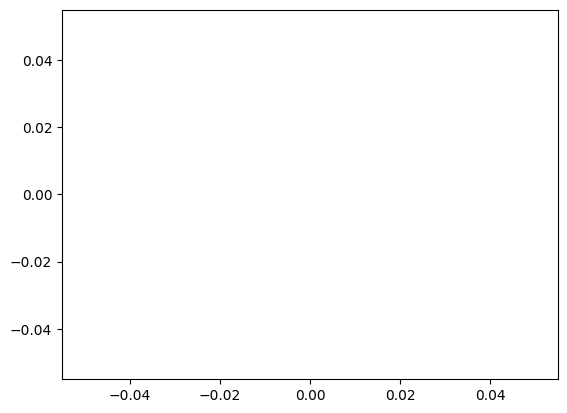

In [132]:
#plot the loss
plt.plot(validation_losses)

In [133]:
from data_pipeline.data_loading import  DfDataset
import pandas as pd

#get the predictions for the model
y_true_validation = []
y_pred_validation = []
validation_dataset_df = pd.read_csv(validation_dataset_path)
validation_data_loader_opp = DfDataset(df=validation_dataset_df, data_path_col=path_to_img_column,label_cols=label_cols, shuffle = False, augmentation=True, transform=validation_dataset.transform)
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [134]:
#count the number of stargradt samples


In [135]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size
#set the verbosity to error

best_thresholds = []

for i in range(len(label_cols)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', label_cols[i], 'at', best_thresholds[i], 'with a score of', best_score)
#save the best thresholds
model_config = {
    'best_thresholds': best_thresholds
}

best_thresholds = torch.Tensor(best_thresholds)



c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Age-related Macular Degeneration at 0.5700000000000001 with a score of 0.7936507936507936
Best thresholds found for class Best Disease at 0.01 with a score of 1.0


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in div

Best thresholds found for class Bietti crystalline dystrophy at 0.06 with a score of 1.0
Best thresholds found for class cataract at 0.17 with a score of 0.983050847457627


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: in

Best thresholds found for class Cone Dystrophie or Cone-rod Dystrophie at 0.18 with a score of 0.8
Best thresholds found for class Diabetic Retinopathy at 0.25 with a score of 0.9206349206349206


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in div

Best thresholds found for class glaucoma at 0.51 with a score of 0.8363636363636364
Best thresholds found for class Maculopathy at 0.23 with a score of 0.8421052631578948


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in div

Best thresholds found for class Myopia at 0.93 with a score of 0.9310344827586207
Best thresholds found for class Normal at 0.29 with a score of 0.7076923076923077


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in div

Best thresholds found for class Retinitis Pigmentosa at 0.27 with a score of 0.9333333333333332
Best thresholds found for class Stargardt Disease at 0.02 with a score of 0.5


c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value encountered in divide
  f_beta = (1 + beta**2) * (precision * recal) / ((beta**2 * precision) + recal)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:174: RuntimeWarning: invalid value enc

In [136]:
print('Best thresholds:', best_thresholds)
print(label_cols)

Best thresholds: tensor([0.5700, 0.0100, 0.0600, 0.1700, 0.1800, 0.2500, 0.5100, 0.2300, 0.9300,
        0.2900, 0.2700, 0.0200])
['Age-related Macular Degeneration', 'Best Disease', 'Bietti crystalline dystrophy', 'cataract', 'Cone Dystrophie or Cone-rod Dystrophie', 'Diabetic Retinopathy', 'glaucoma', 'Maculopathy', 'Myopia', 'Normal', 'Retinitis Pigmentosa', 'Stargardt Disease']


In [137]:
#execute the model on the test set
y_true = []
y_pred = []
x = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
        x.append(inputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()
X_test = torch.cat(x, dim=0).cpu()

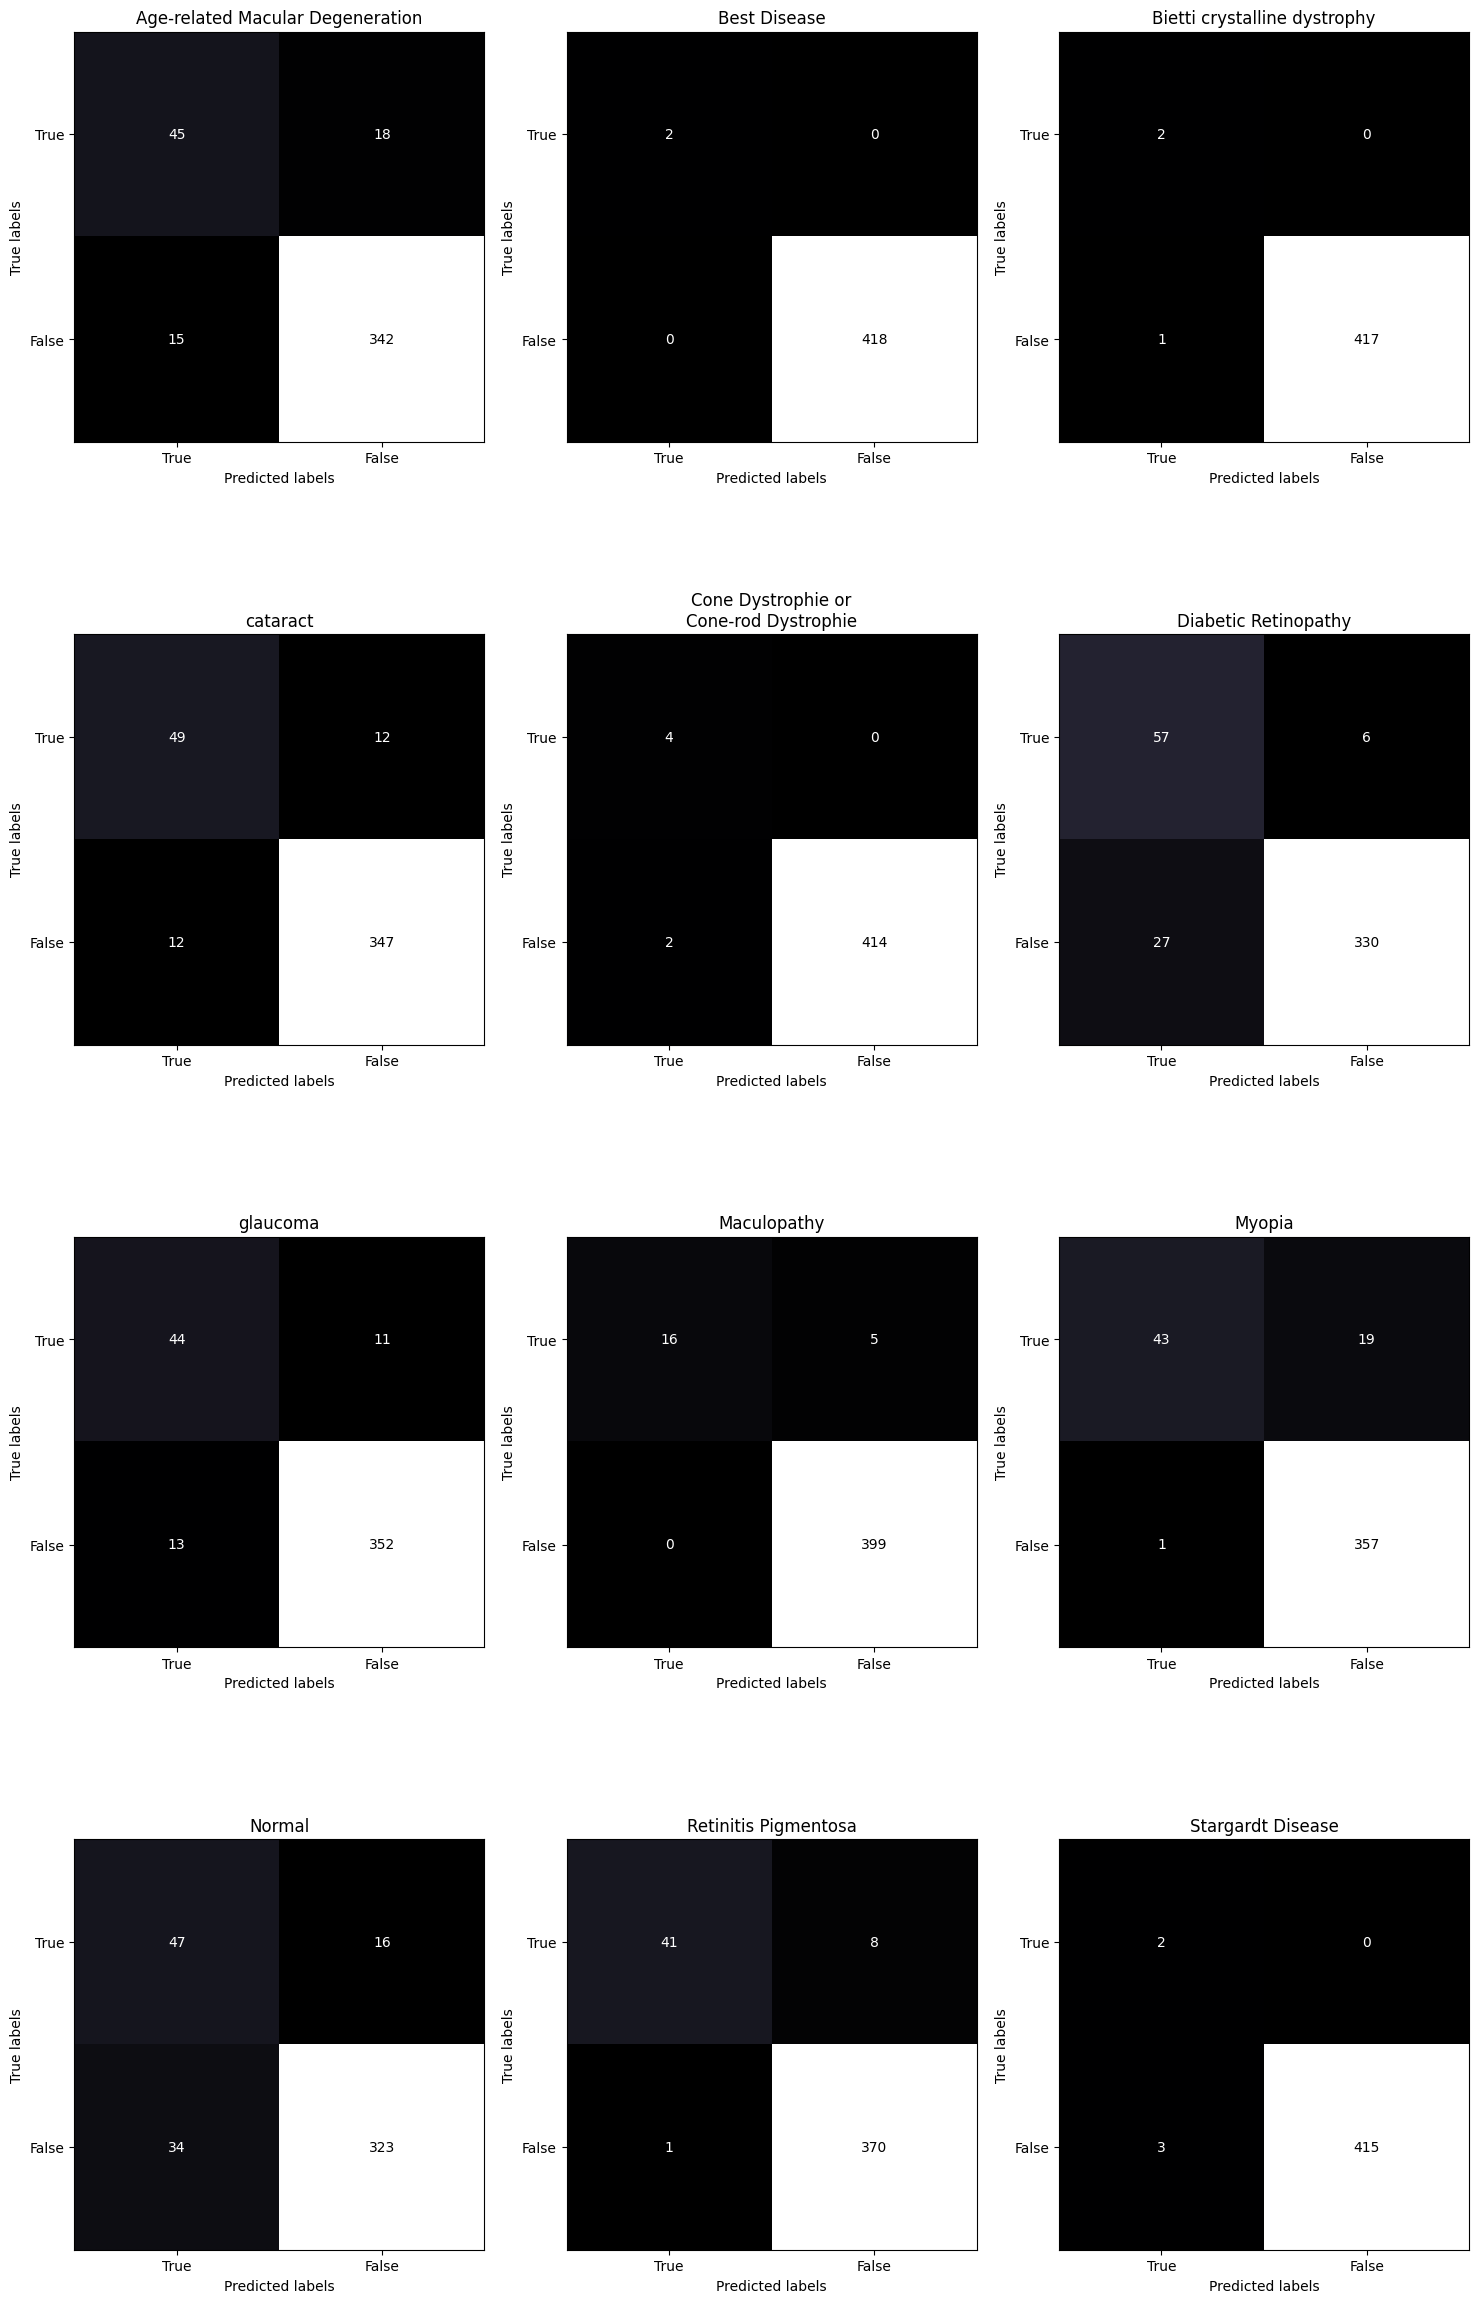

In [138]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(train_dataset.classes) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = train_dataset.classes[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

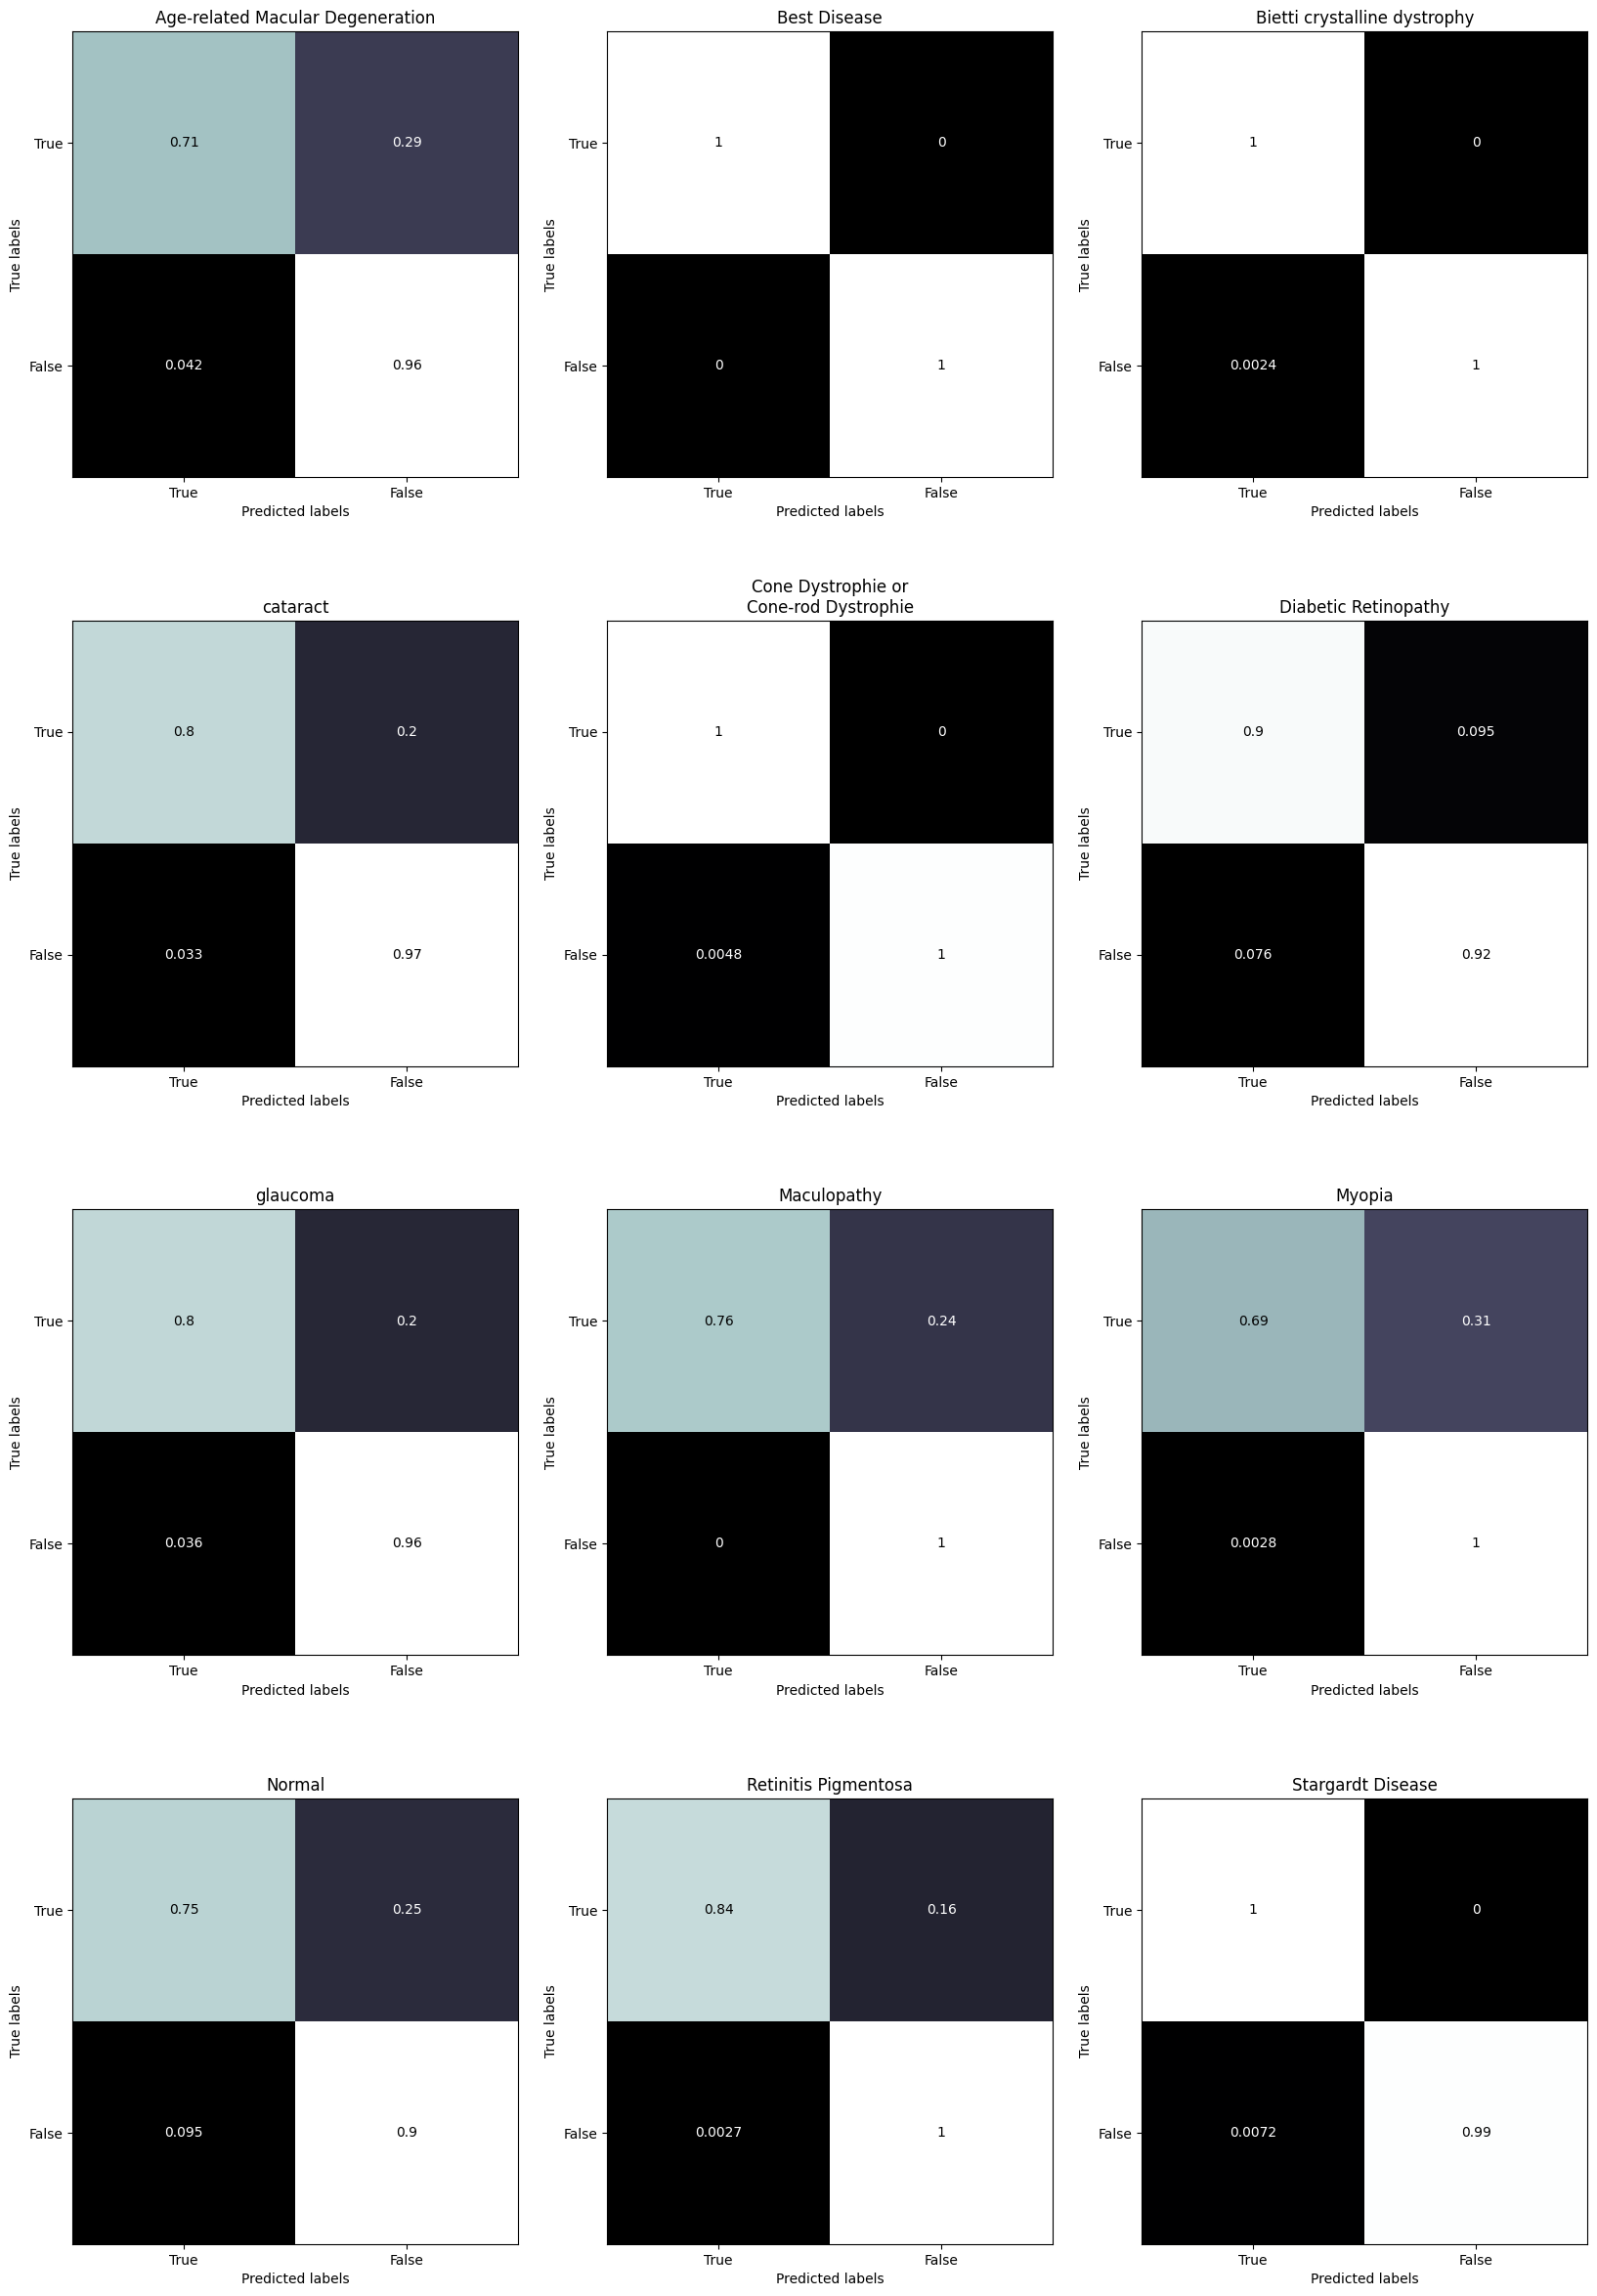

In [139]:
#plot the same confusion matrices with the row normalised values
cm_normalizer = confusion_matrices.sum(axis=2)#[:,np.newaxis]
#add a new dimension to the normalizer
cm_normalizer = cm_normalizer[:,np.newaxis]
#add a copy of the normalizer to the normalizer

#cm_normalizer = np.concatenate([cm_normalizer, cm_normalizer], axis=0)
reversed_normalizer = np.flip(cm_normalizer, axis=-1)
cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
#flip the normalizer
cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
normalised_cms = confusion_matrices / cm_normalizer
flipped_normalised_cms = np.flip(np.flip(normalised_cms, axis=-1), axis=-2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=flipped_normalised_cms[i], display_labels=['True', 'False'])
    #turn off color bar

    disp.plot(ax=ax, colorbar=False, cmap='bone')
    title = train_dataset.classes[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

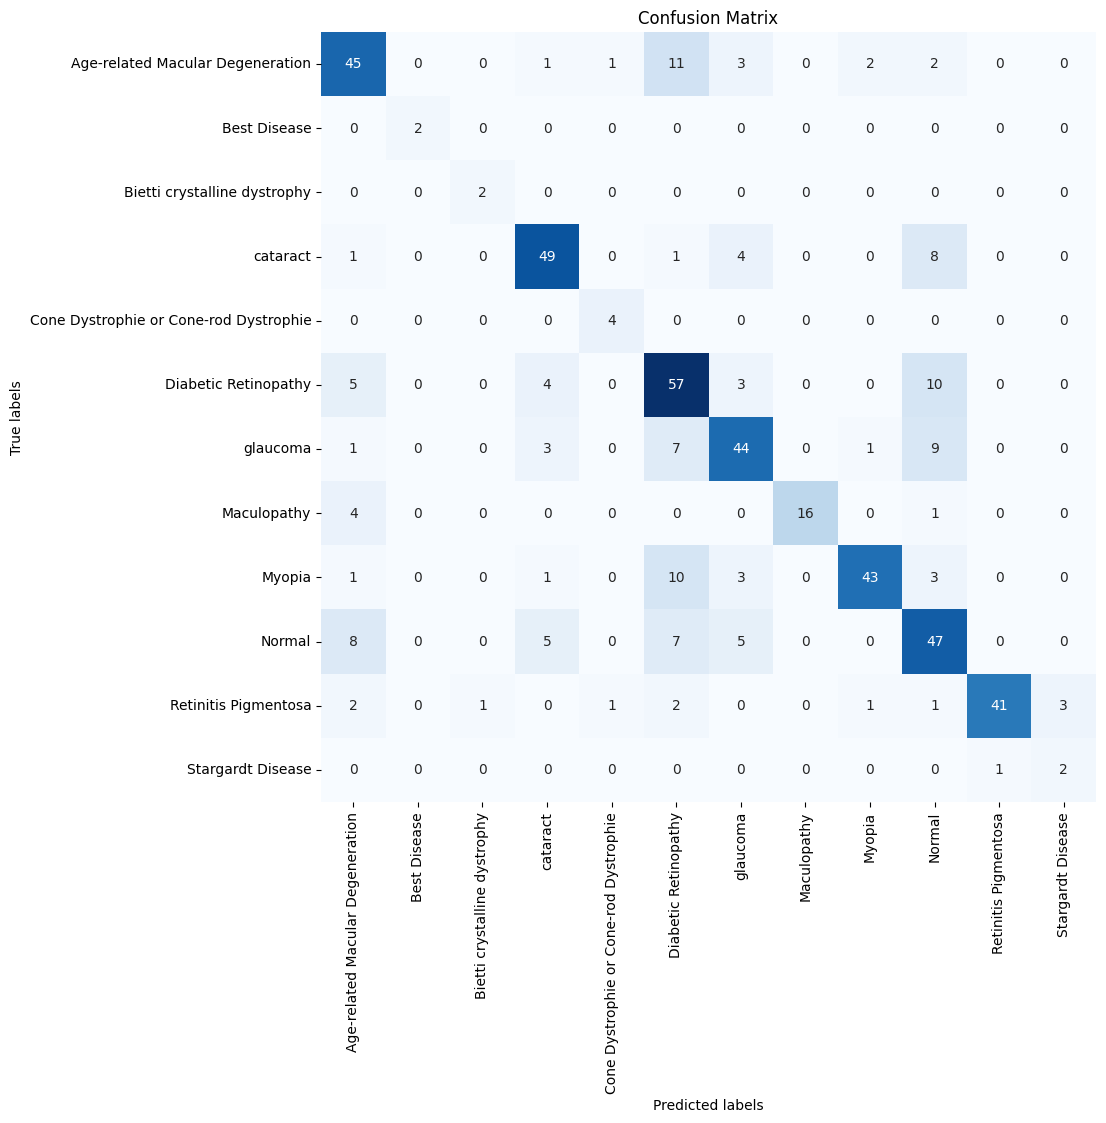

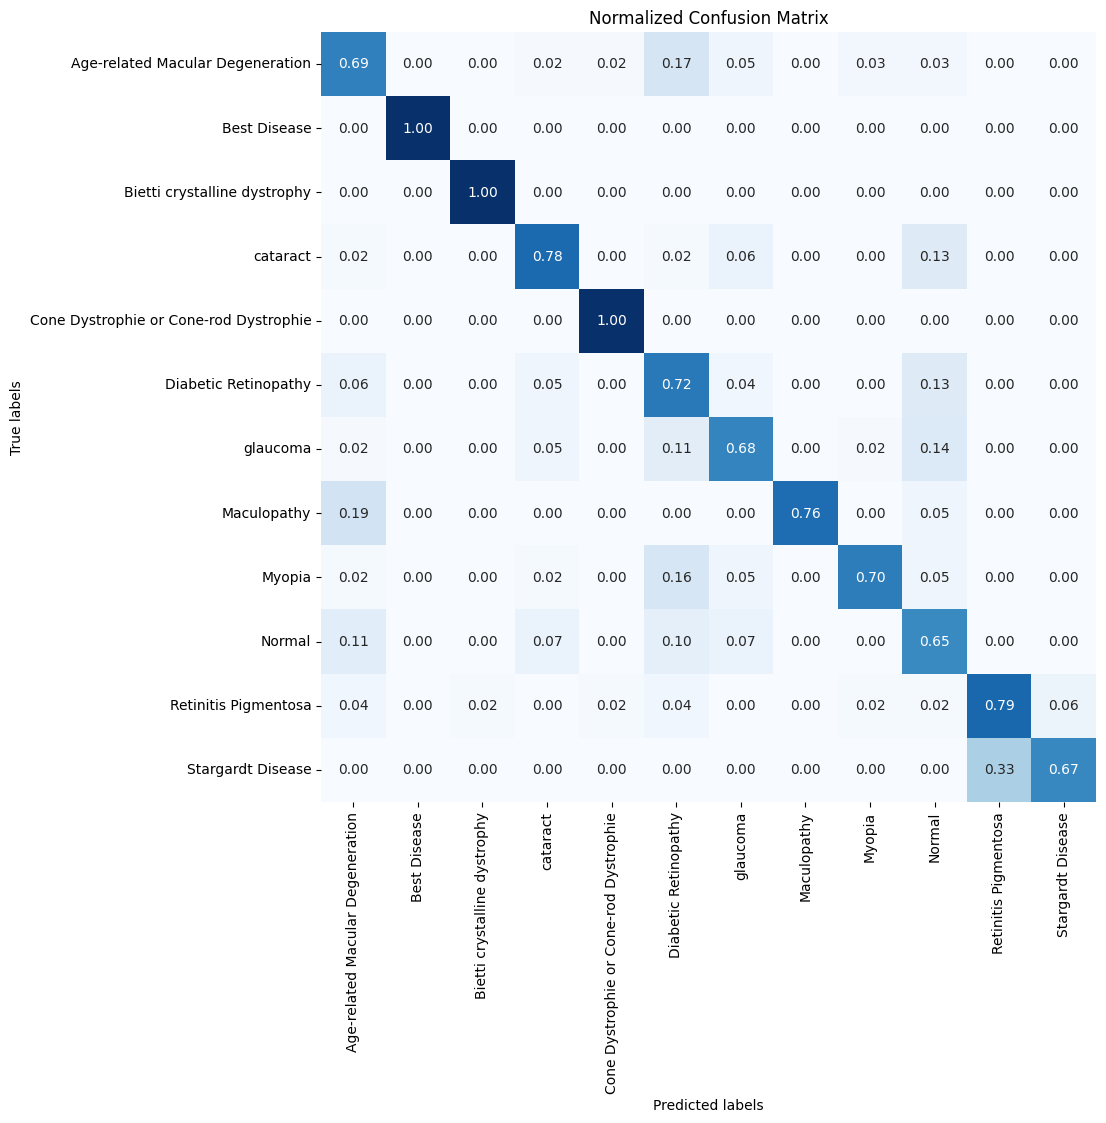

In [140]:
#generate a n_classes x n_classes matrix
#initialize the matrix
import seaborn as sns
confusion_matrix = np.zeros((n_classes, n_classes))
for i in range(n_classes):
    #find all the indexes where the true label is i
    indexes = y_true[:, i] == 1
    #sum the indexes
    #find the predicted labels
    predicted_labels = y_pred_cm[indexes]
    confusion_matrix[i] = predicted_labels.sum(dim=0)
#plot the confusion matrix
# Using seaborn for a visually appealing heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='g',
             cmap='Blues', xticklabels=label_cols, yticklabels=label_cols, ax=ax, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
#do the same with normalized confusion matrix
#normalize the confusion matrix
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
#plot the confusion matrix
# Using seaborn for a visually appealing heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, fmt='.2f',
             cmap='Blues', xticklabels=label_cols, yticklabels=label_cols, ax=ax, cbar=False)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [141]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
print(f'Precision macro: {precision:.2f}')
print(f'Recall macro: {recall:.2f}')
print(f'Accuracy macro: {accuracy:.2f}')
print(f'F1 macro: {f1:.2f}')
print('-----------------------------------')
#do the same for the micro scores
precision = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)
print(f'Precision micro: {precision:.2f}')
print(f'Recall micro: {recall:.2f}')
print(f'Accuracy micro: {accuracy:.2f}')
print(f'F1 micro: {f1:.2f}')


TP: 352
FP: 109
TN: 4484
FN: 95
-----------------------------------
Precision macro: 0.77
Recall macro: 0.86
Accuracy macro: 0.96
F1 macro: 0.81
-----------------------------------
Precision micro: 0.76
Recall micro: 0.79
Accuracy micro: 0.96
F1 micro: 0.78


In [142]:
def calculate_cm_normalizers(cms : np.ndarray):
    cm_normalizer = cms.sum(axis=2)[:,np.newaxis]
    #add a copy of the normalizer to the normalizer
    reversed_normalizer = np.flip(cm_normalizer, axis=-1)
    cm_normalizer=np.concatenate([cm_normalizer, reversed_normalizer], axis=1)
    #flip the normalizer
    cm_normalizer[:,:,1] = cm_normalizer[:,0,:]
    return cm_normalizer

In [143]:

def generate_binary_classwise_cms(y_true : torch.Tensor, y_pred : torch.Tensor, best_thresholds : torch.Tensor,
                                   dataset : DfDataset, normalize : bool = False):
    y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
    #calculate the confusion matrices on the test set
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
    if normalize:
        confusion_matrices = confusion_matrices / calculate_cm_normalizers(confusion_matrices)
    flipped_confusion_matrices = np.flip(confusion_matrices, axis=-1)
    flipped_confusion_matrices = np.flip(flipped_confusion_matrices, axis=-2)
    #plot the confusion matrices, one for each class, 3 per row
    n_cols = 3
    n_rows = int(np.ceil(len(dataset.classes) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 30))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        #use the confusion matrix to plot the confusion matrix
        cm = confusion_matrices[i]
        disp = ConfusionMatrixDisplay(confusion_matrix=flipped_confusion_matrices[i], display_labels=['True', 'False'])
        #turn off color bar

        disp.plot(ax=ax, colorbar=False, cmap='bone')
        title = dataset.classes[i]
        #split the title into multiple lines if it is too long
        if title.count(' ') > 2:
            #split every 3rd space
            title = title.split(' ')
            title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
            title = '\n'.join(title)
        ax.set_title(title)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
    return confusion_matrices

In [144]:
dataset_wise_metrics_save_folder = f'plots/dataset_wise_metrics/{dataset_name}/{model_key}/{transform_type}'
os.makedirs(dataset_wise_metrics_save_folder, exist_ok=True)


Calculating classwise metrics for dataset: ODIR-5K


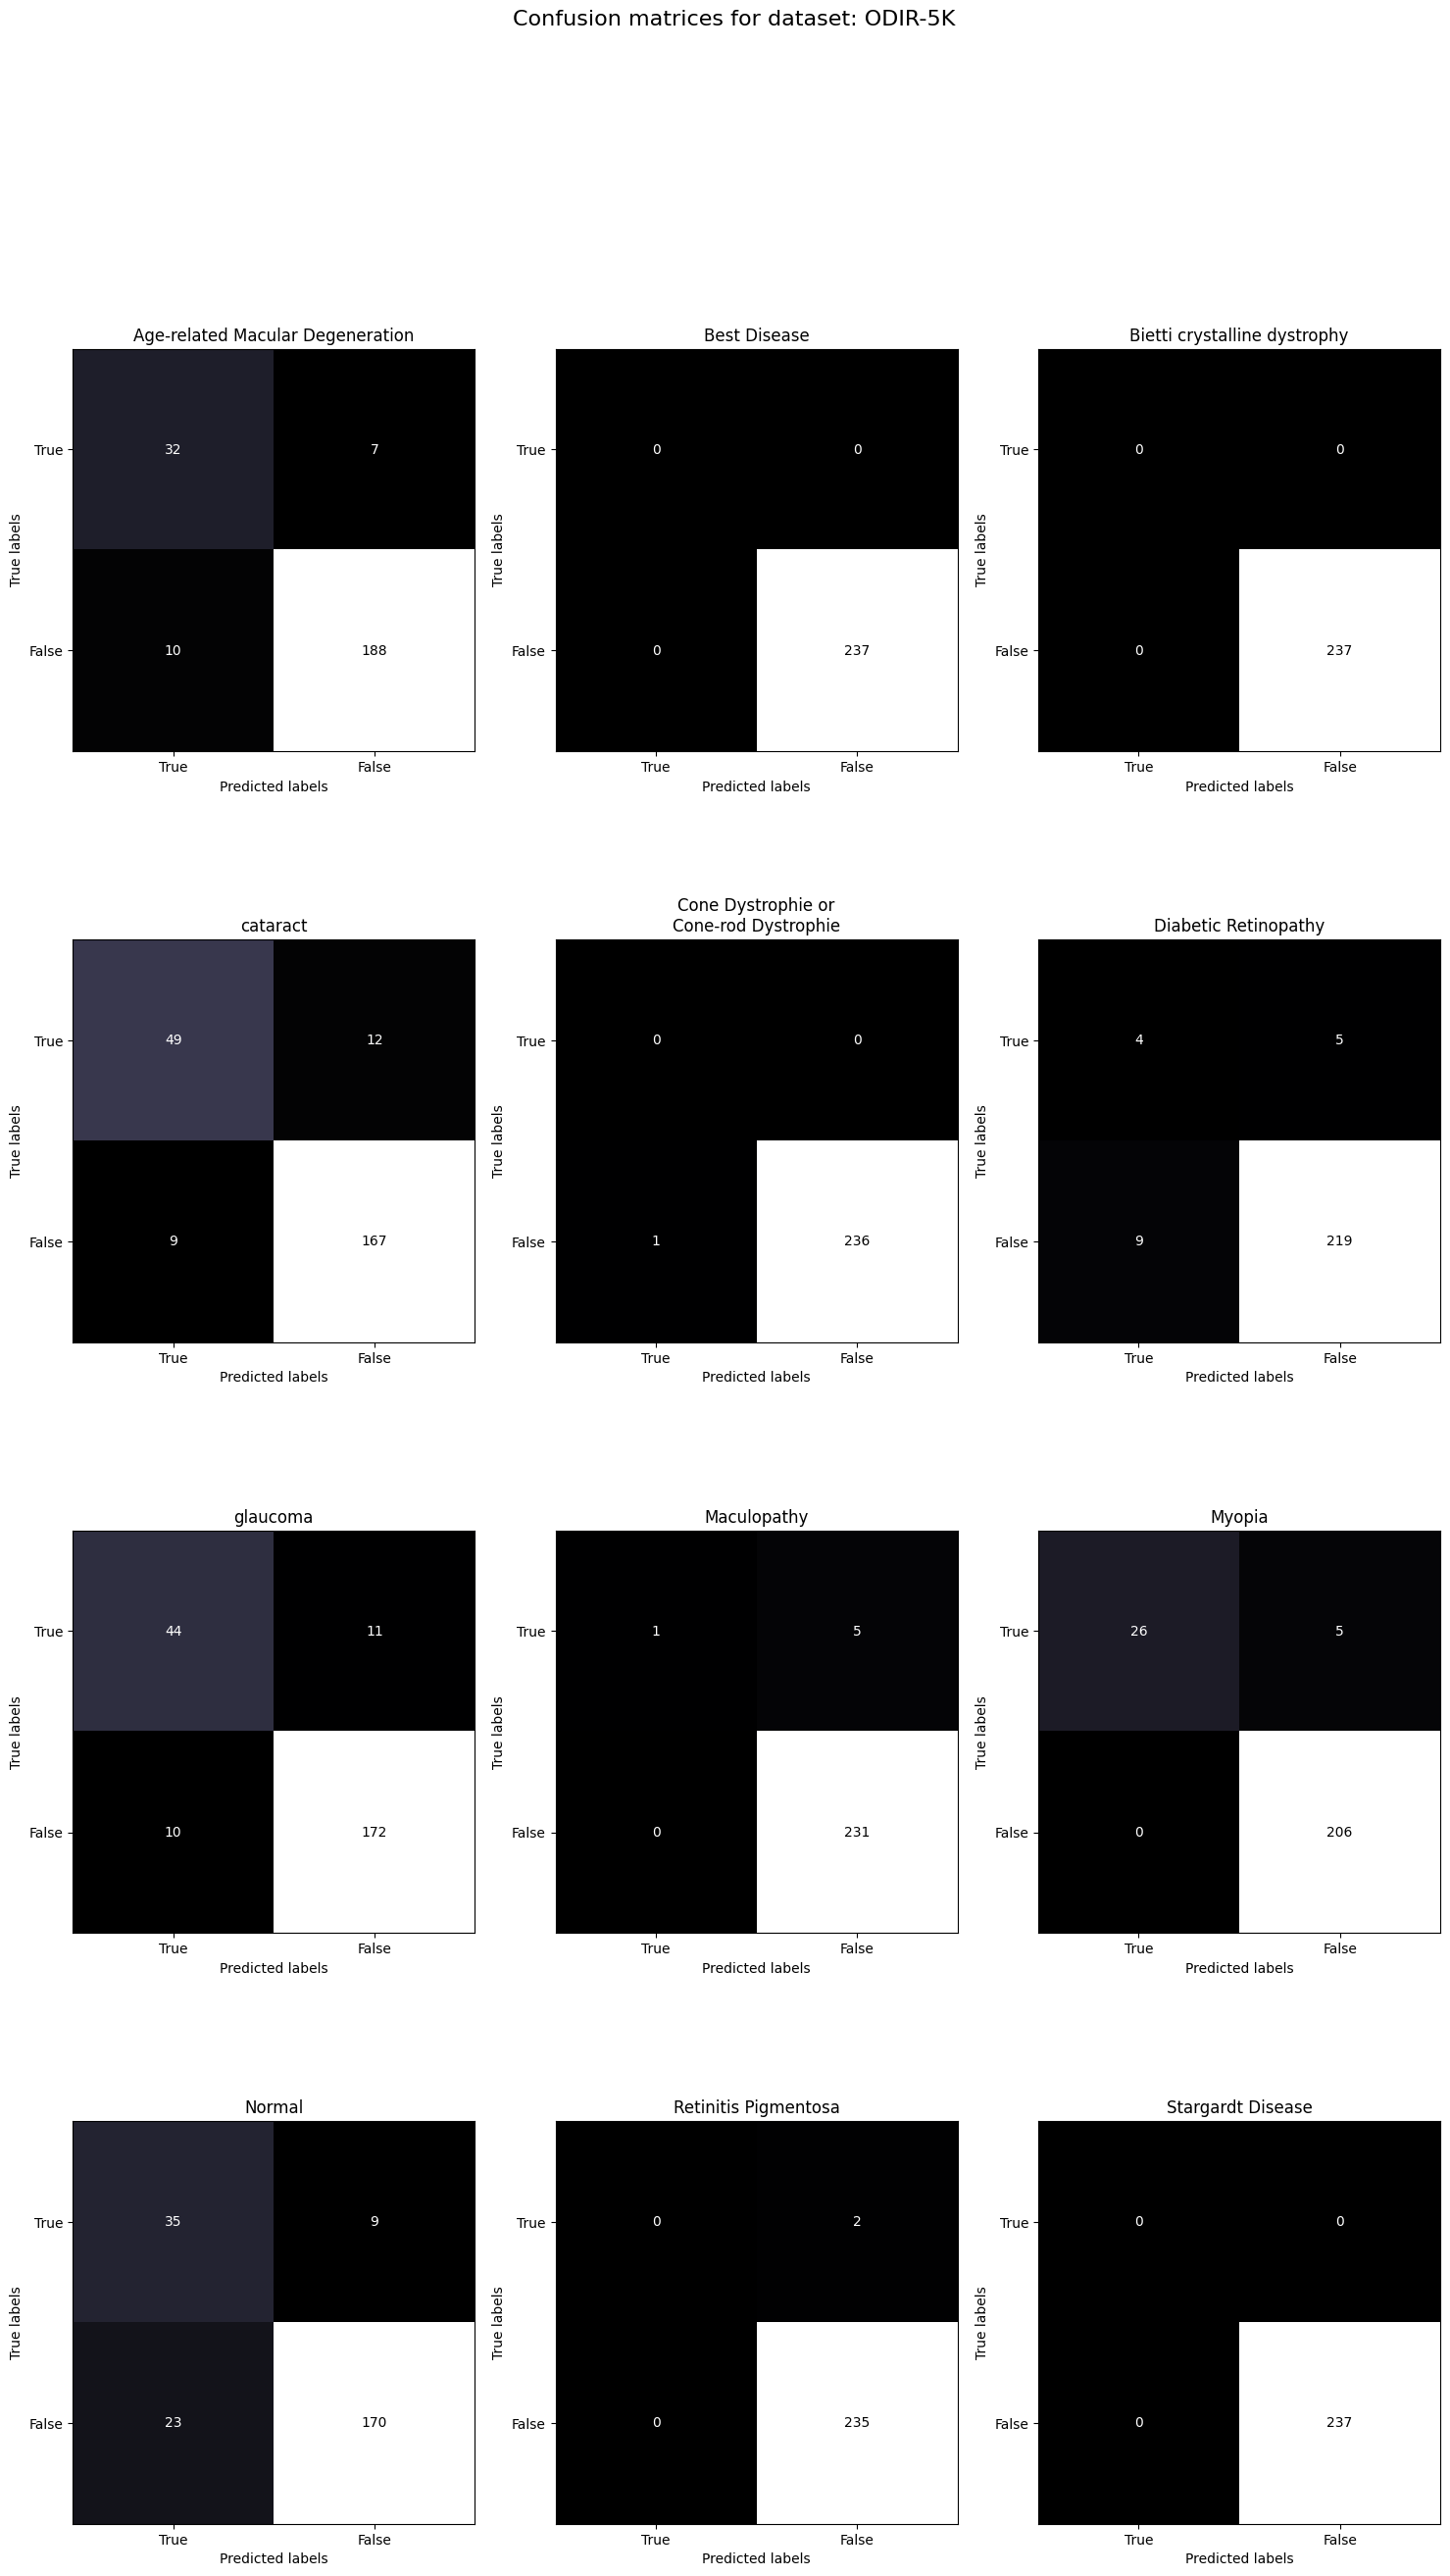

Calculating classwise metrics for dataset: SES


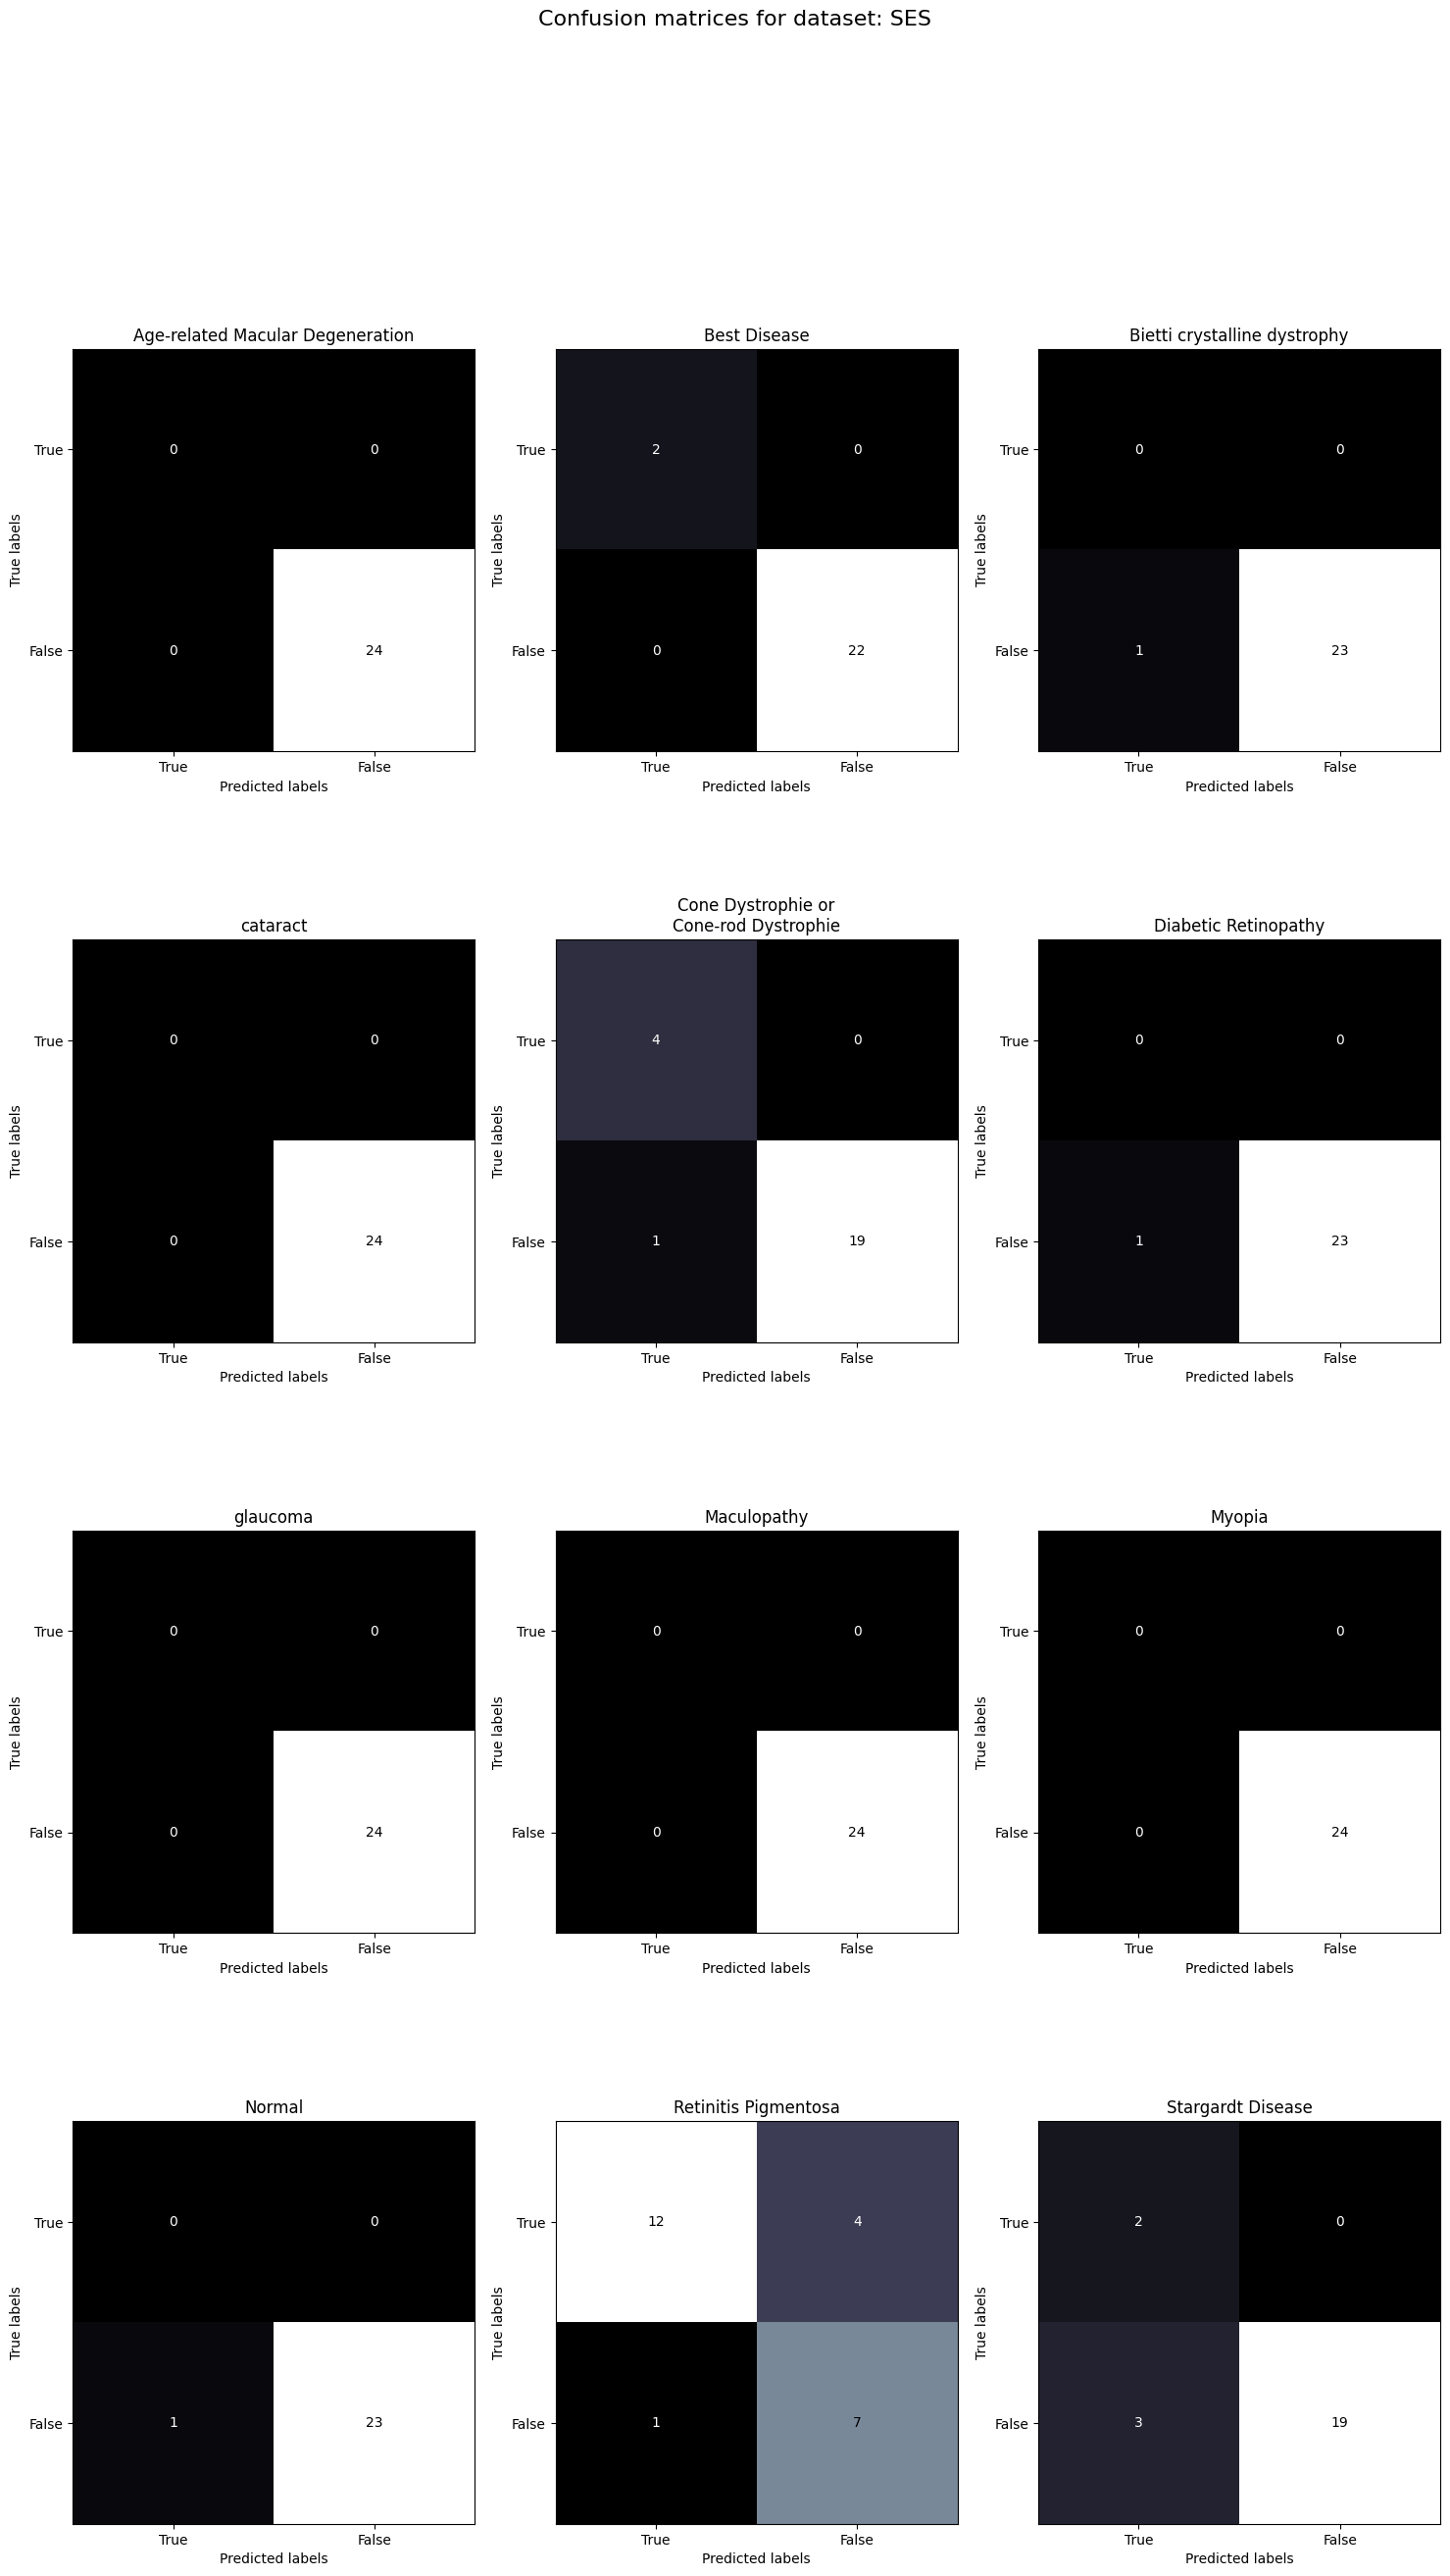

Calculating classwise metrics for dataset: 1000images


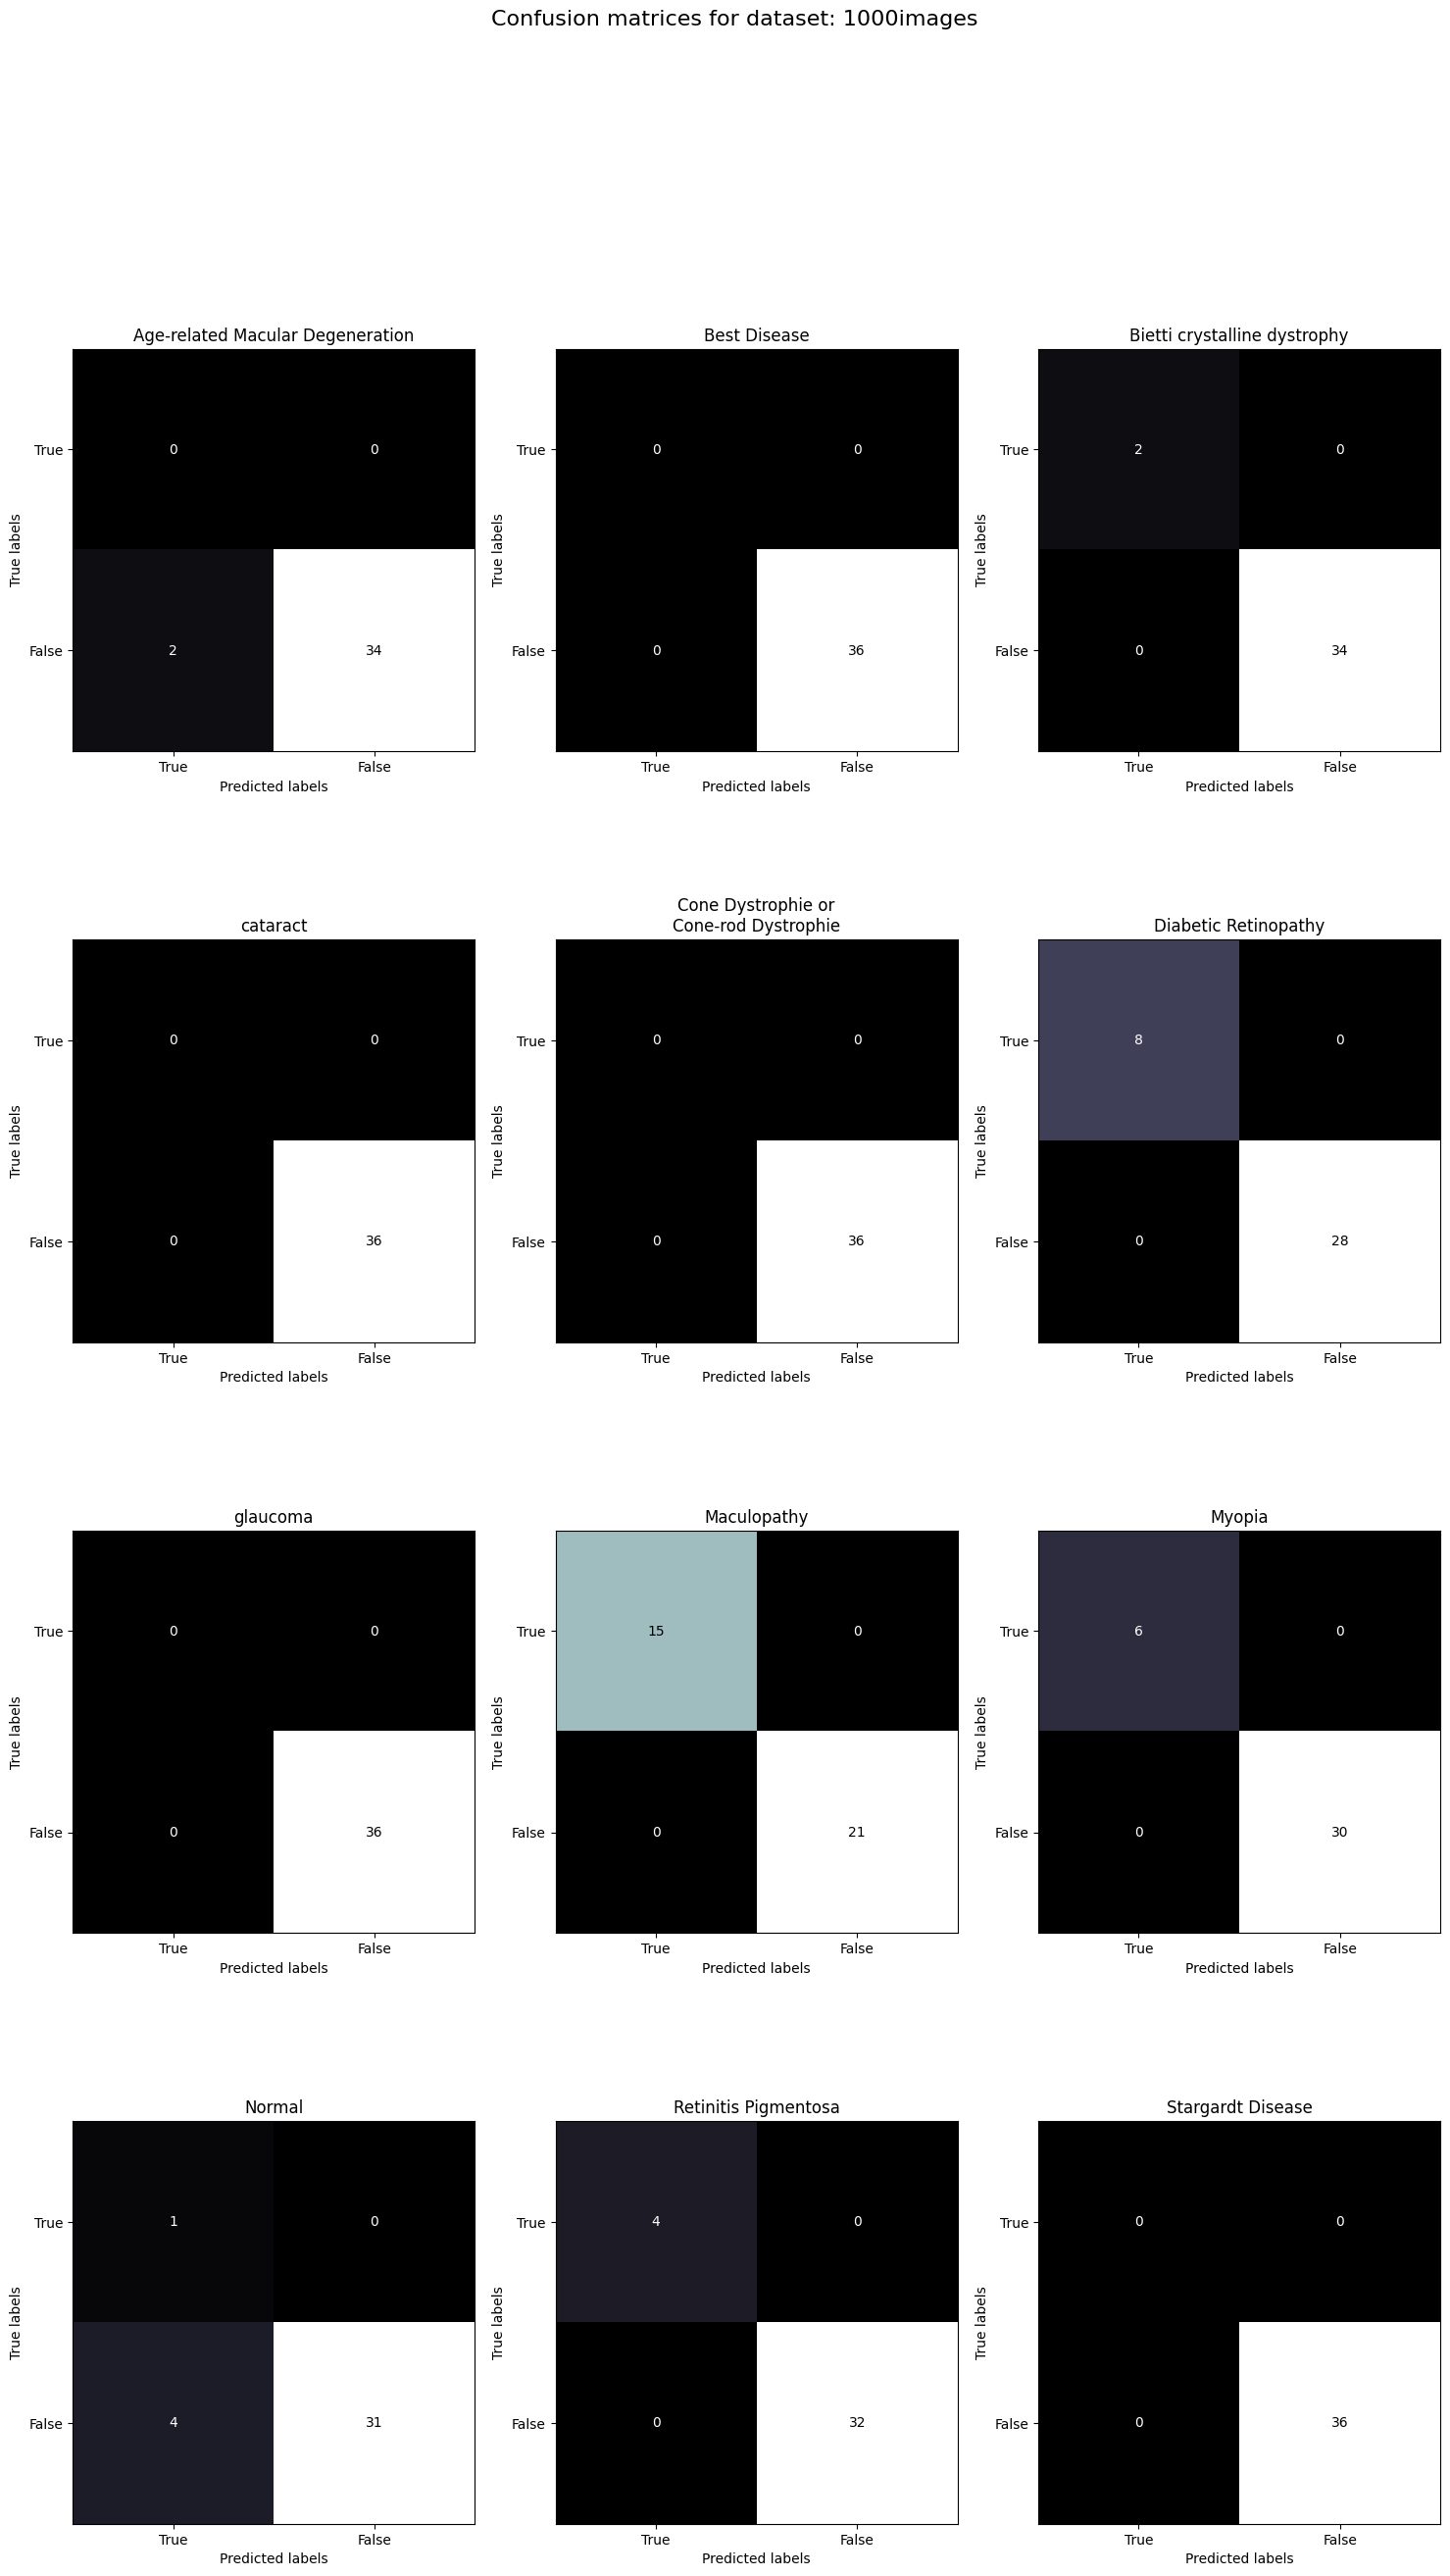

Calculating classwise metrics for dataset: RIPS


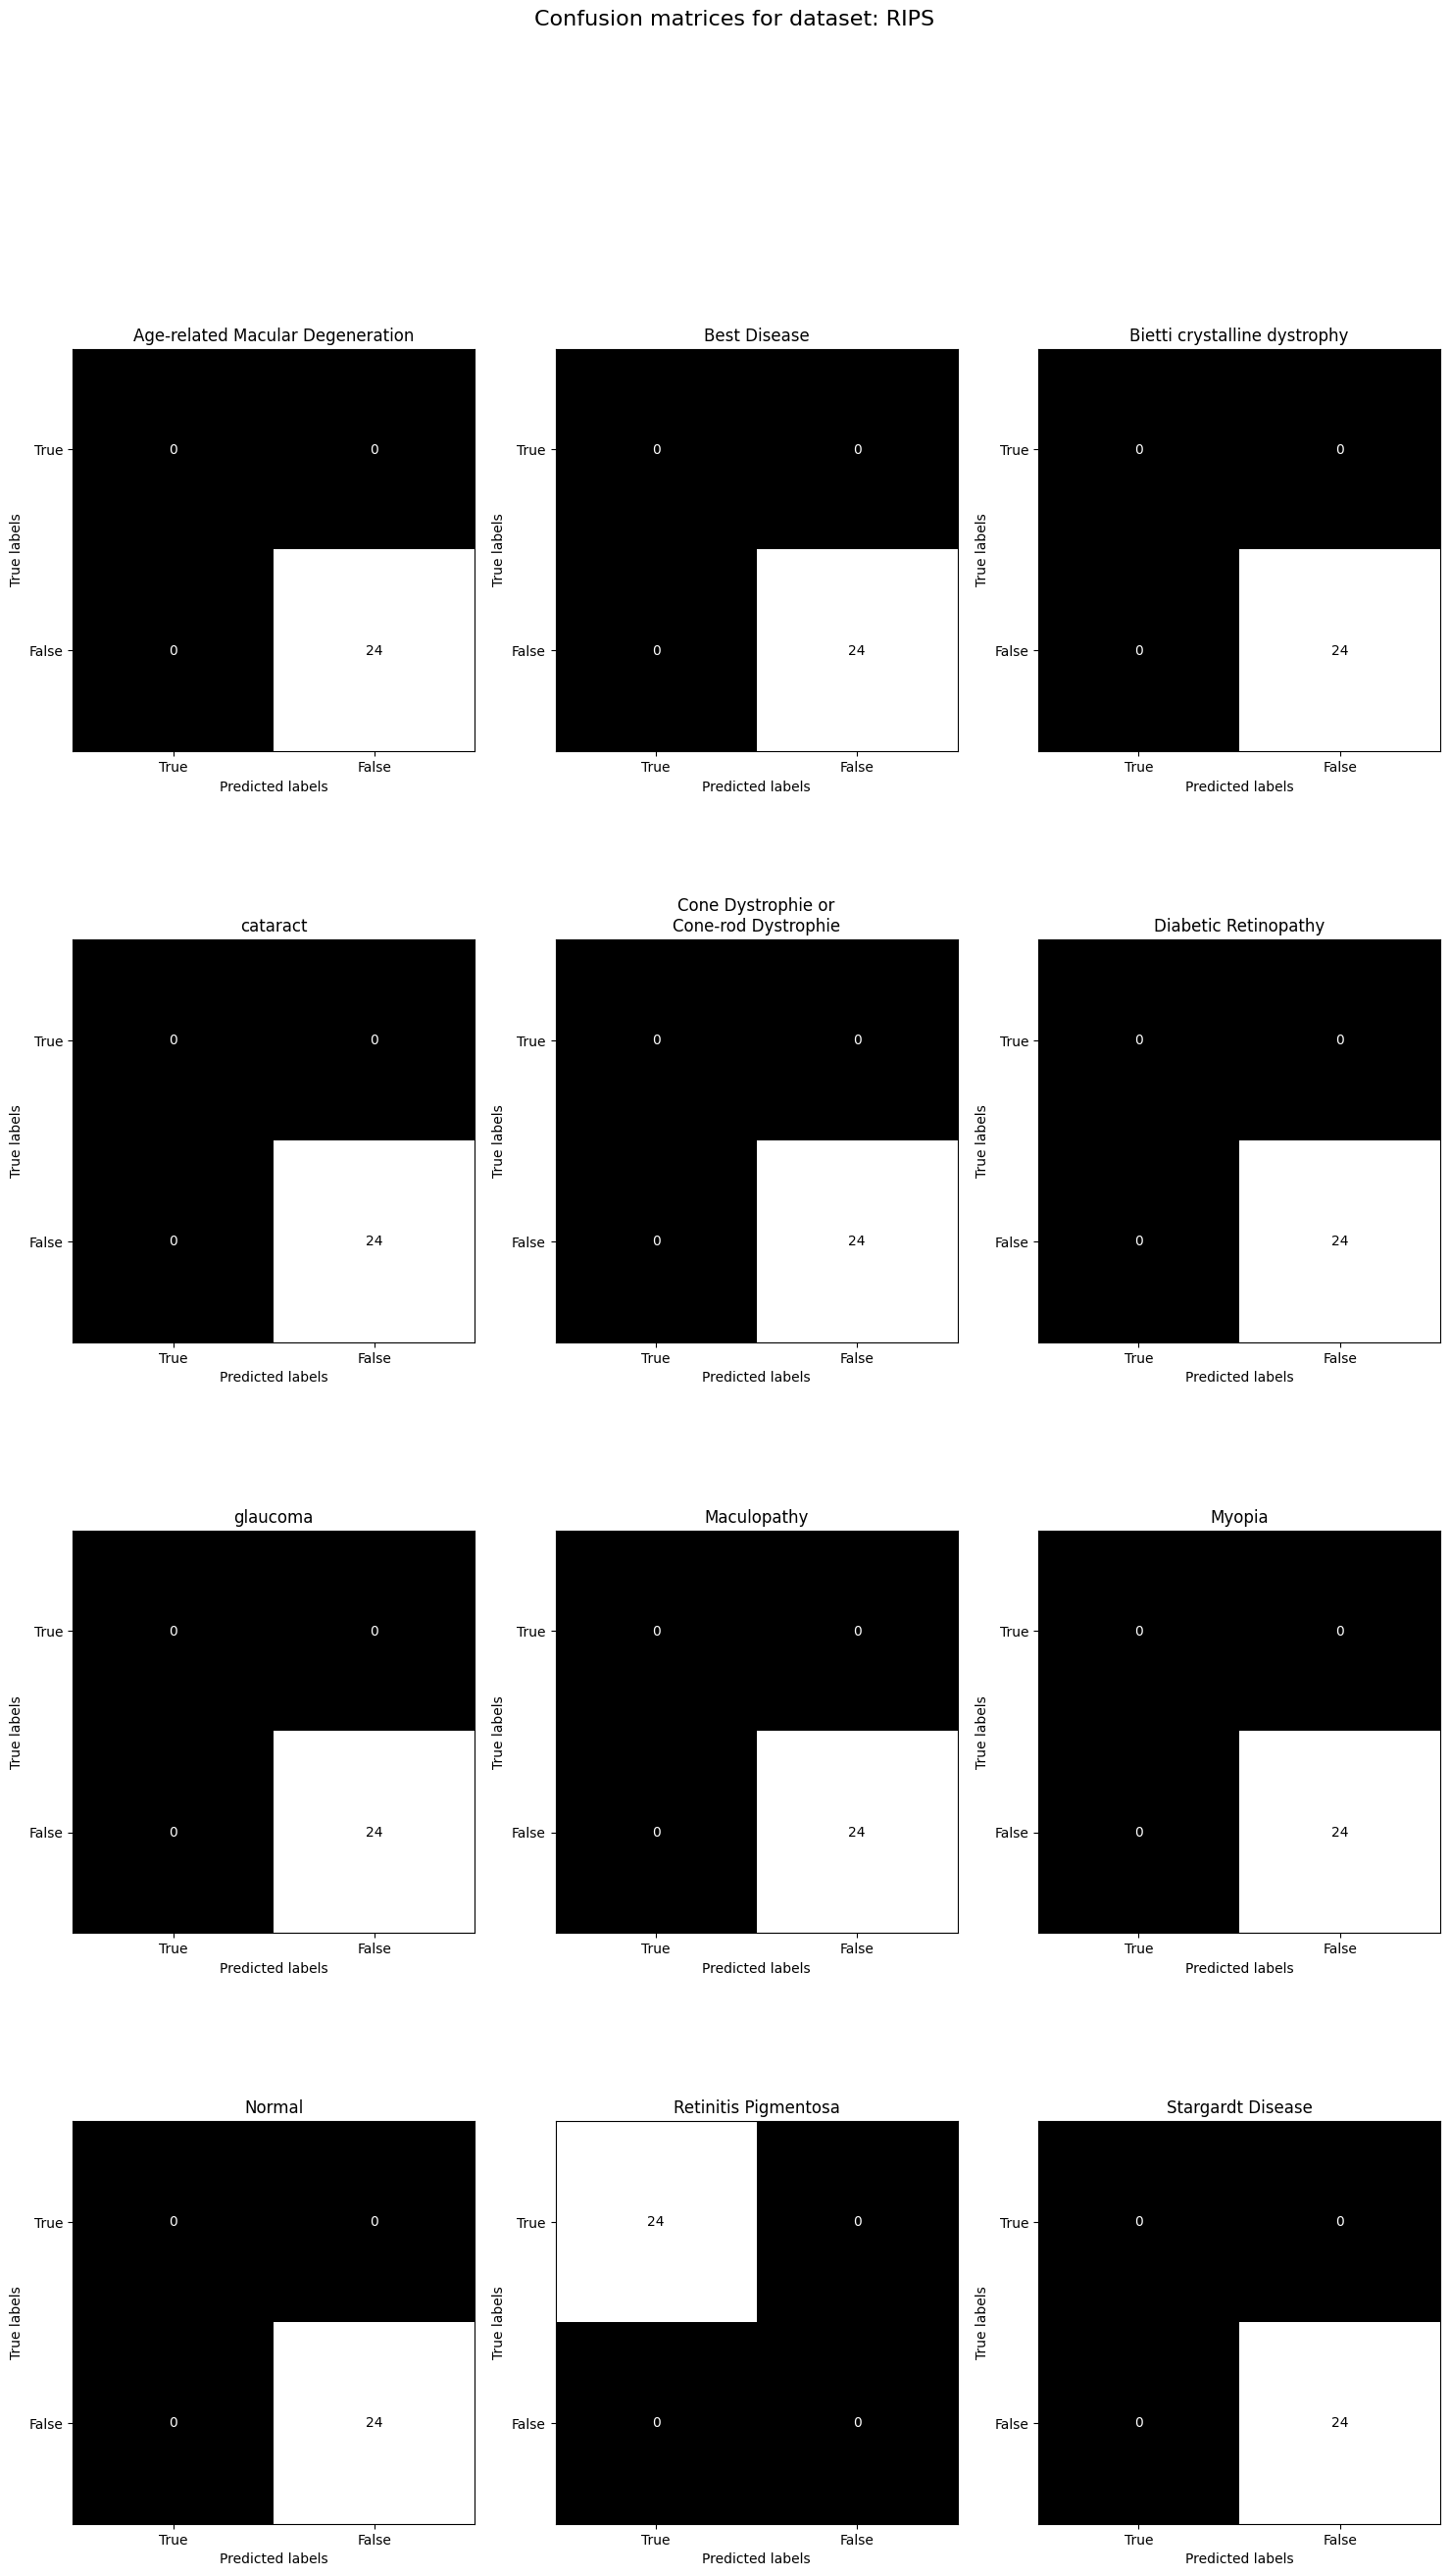

Calculating classwise metrics for dataset: RFMiD2


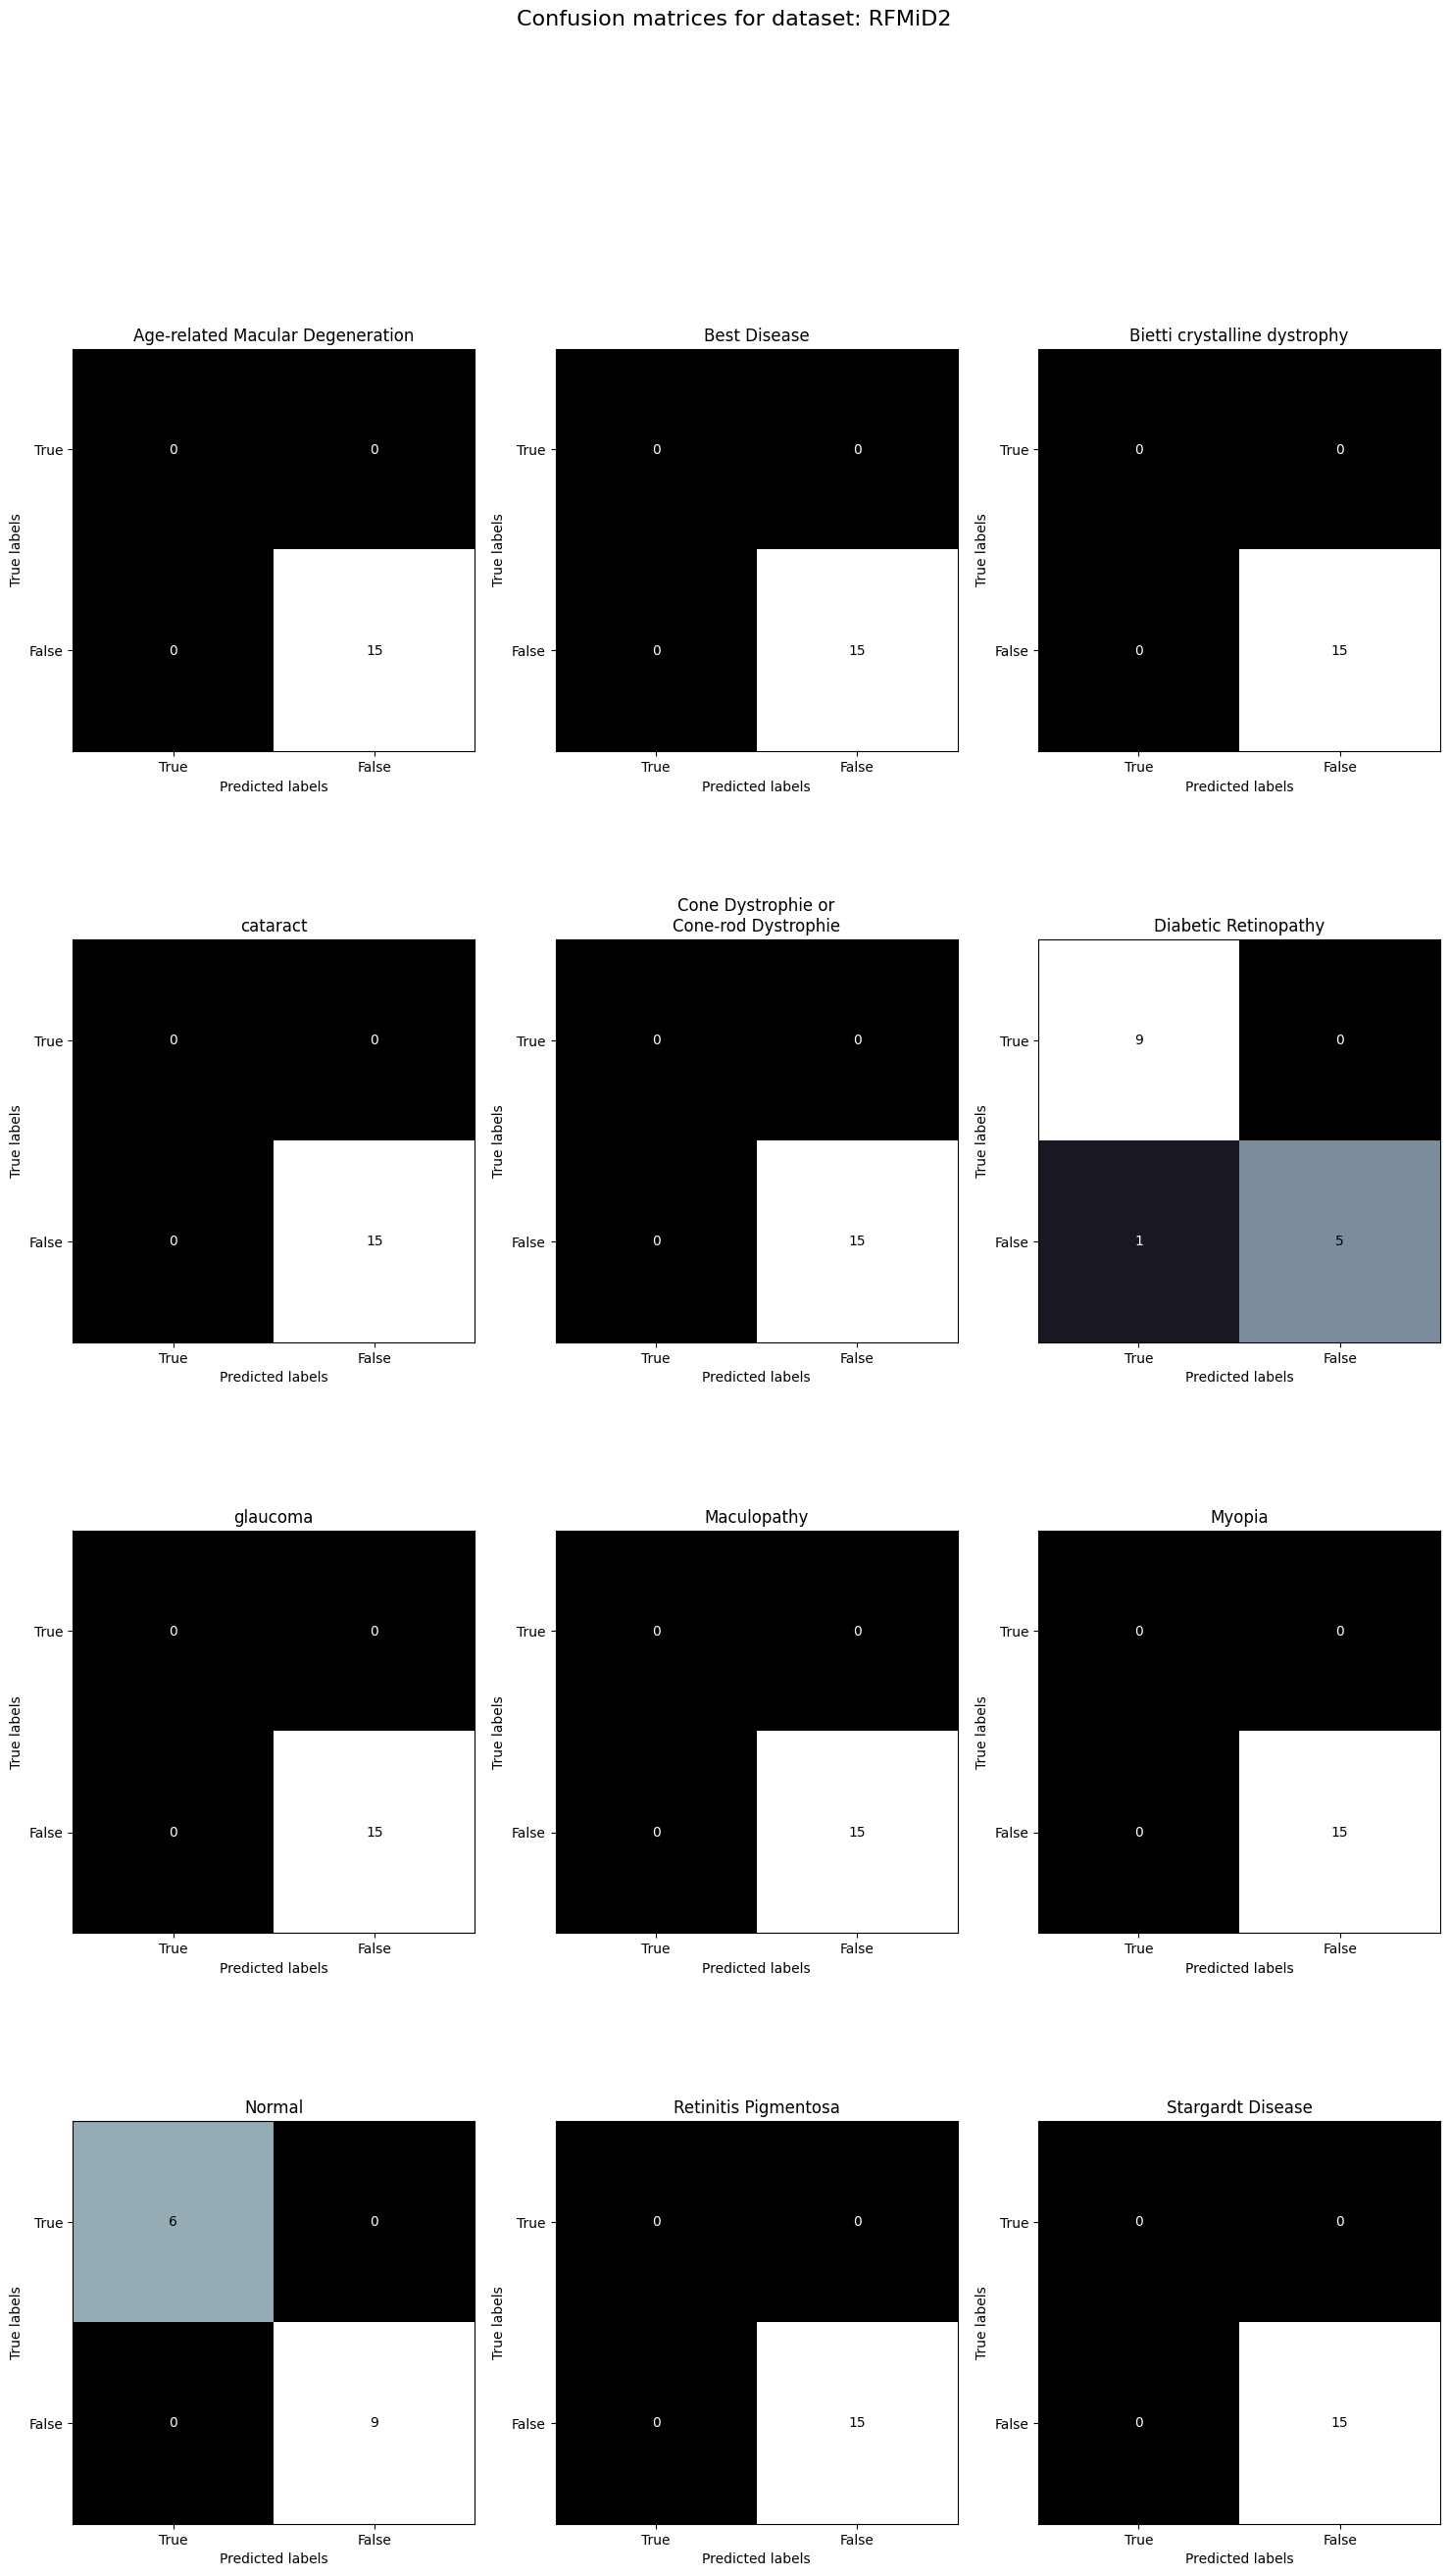

Calculating classwise metrics for dataset: RFMiD


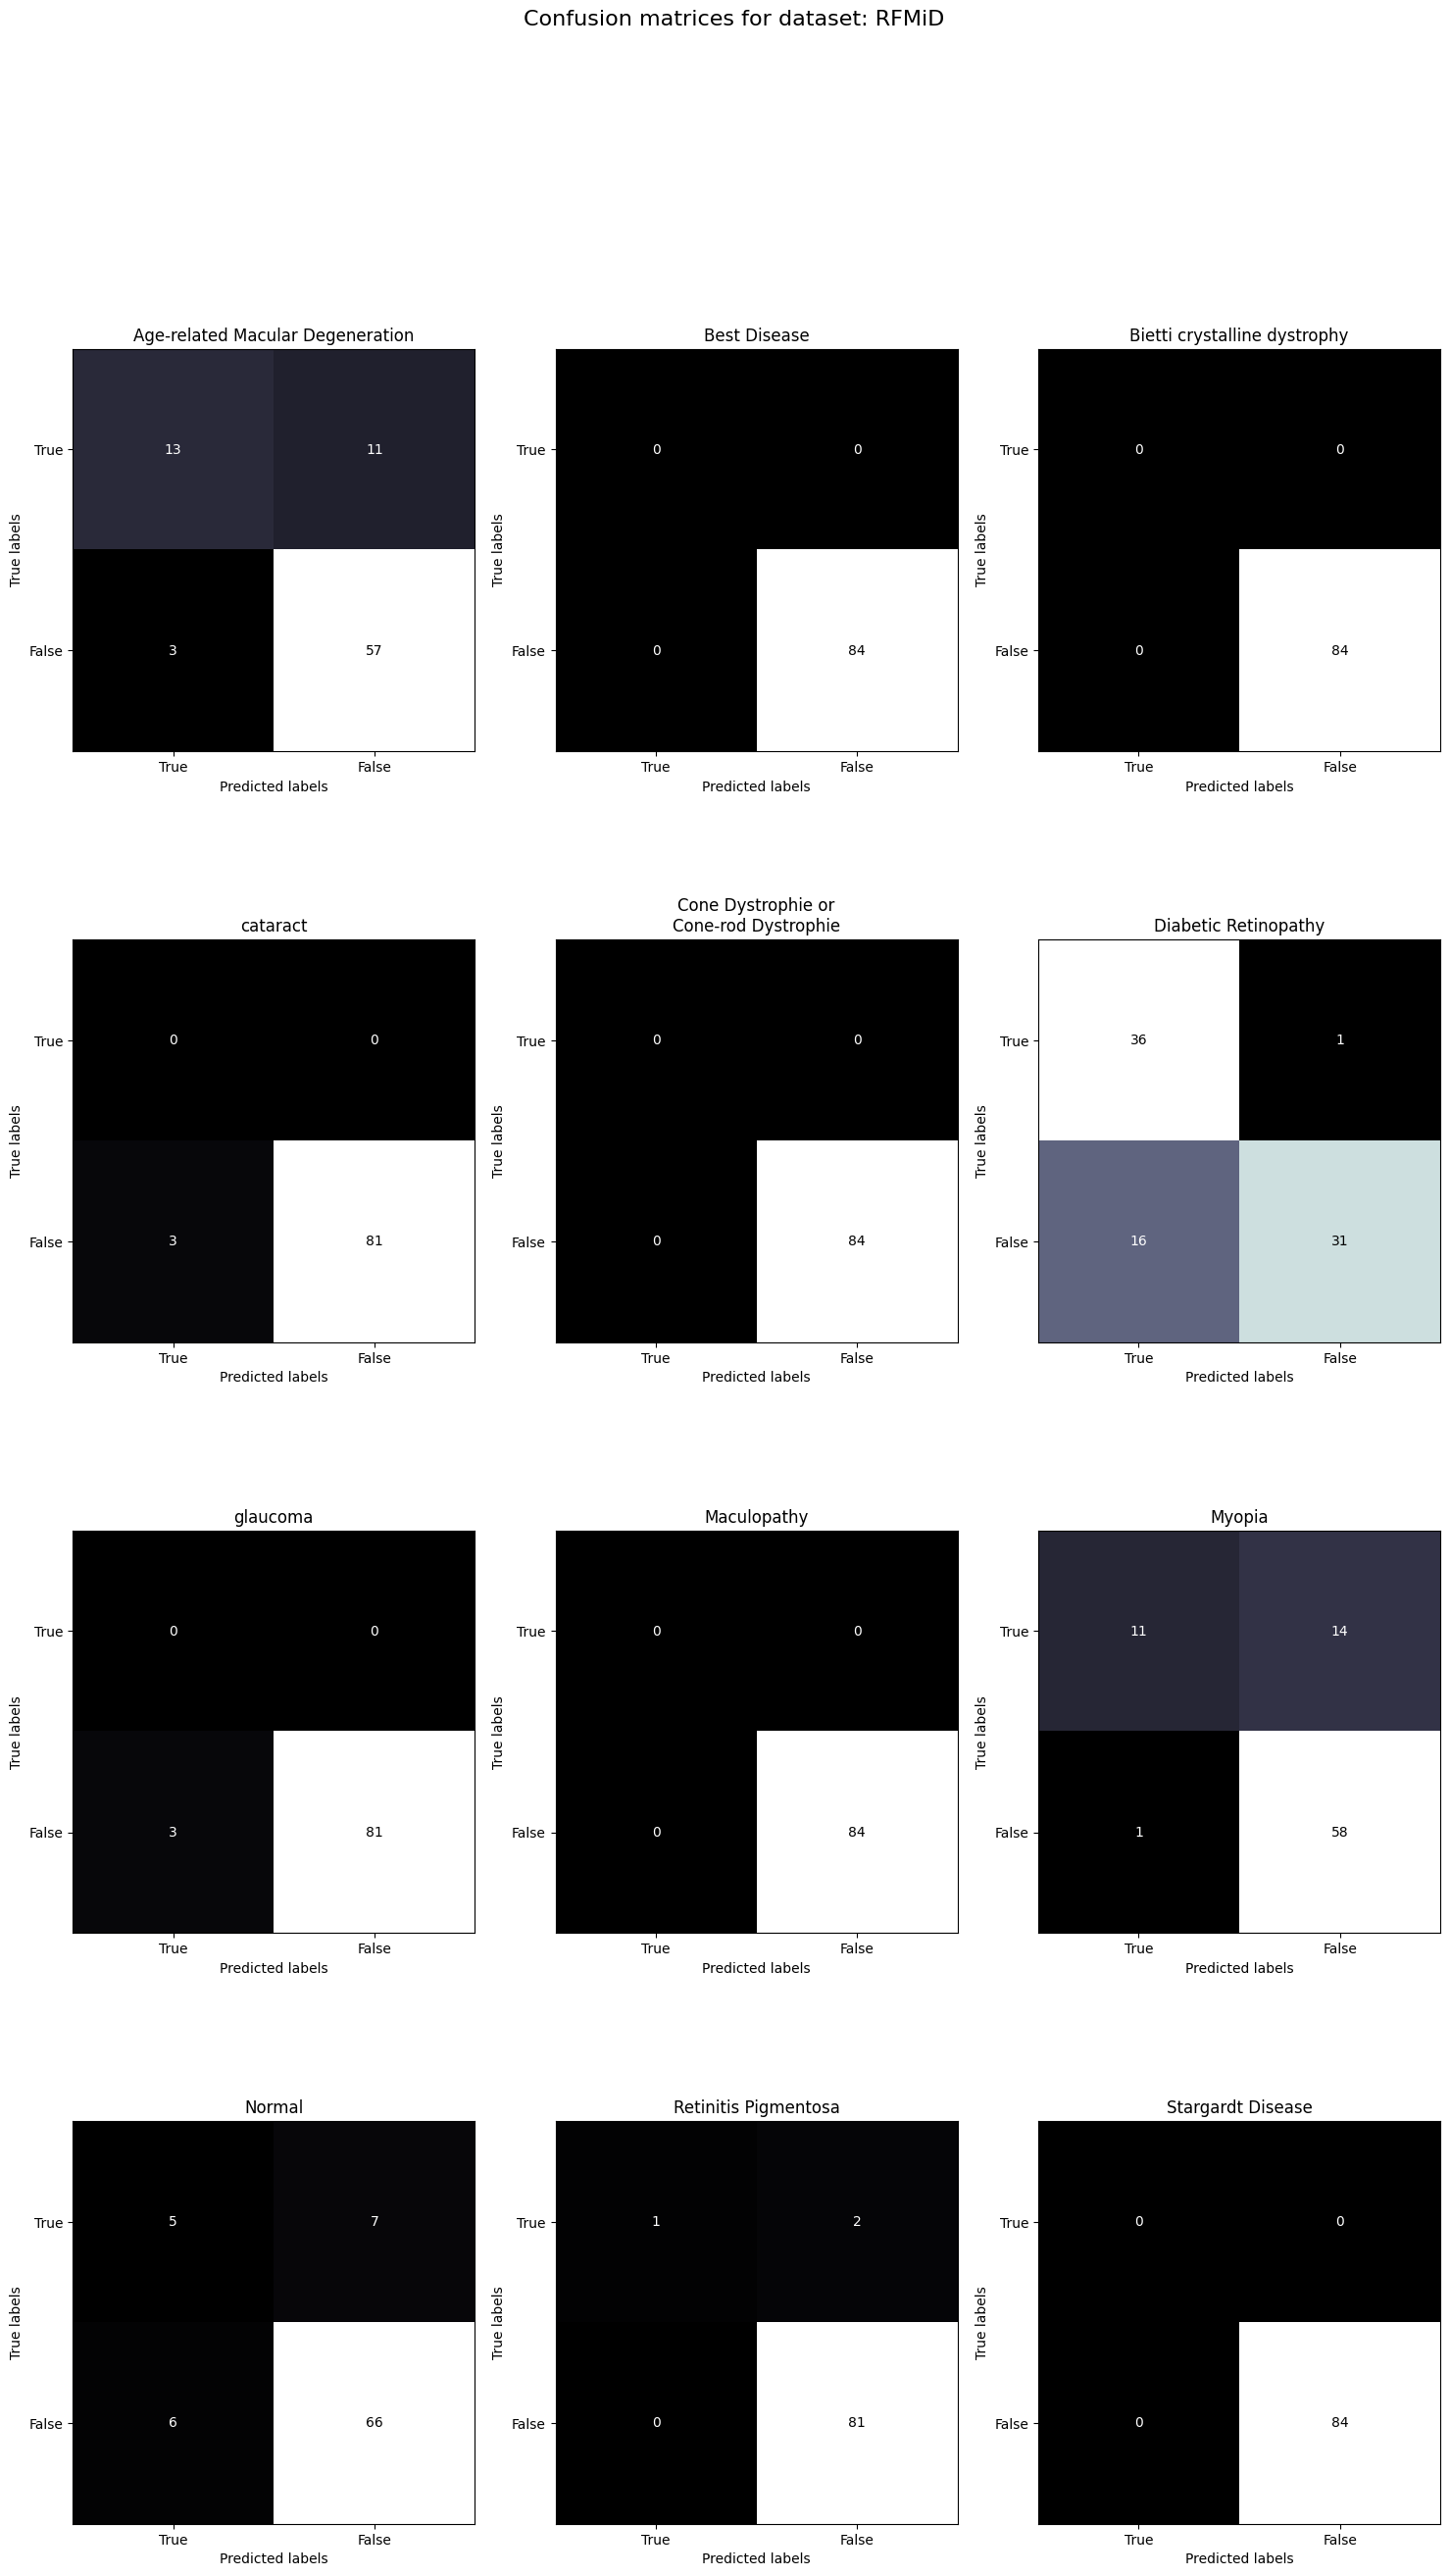

In [145]:
#find the indexes of each dataset from the unique values in the dataset_name column
dataset_names = test_dataset.df['dataset_name'].unique()
dataset_indexes = []
for dataset_name in dataset_names:
    bools = test_dataset.df['dataset_name'] == dataset_name
    indexes = np.where(bools)[0]
    dataset_indexes.append(indexes)

#calculate the classwise metrics for each dataset
dataset_wise_cms = []
for i, indexes in enumerate(dataset_indexes):
    y_true_group = y_true[indexes]
    y_pred_group = y_pred[indexes]
    threshold_tensor = torch.Tensor(best_thresholds)
    print('Calculating classwise metrics for dataset:', dataset_names[i])
    dataset_wise_cms.append(generate_binary_classwise_cms(y_true_group, y_pred_group, threshold_tensor, test_dataset, normalize=False))
    plt.suptitle(f'Confusion matrices for dataset: {dataset_names[i]}', fontsize=16)
    #create a folder for the dataset if it does not exist
    dataset_folder = f'{dataset_wise_metrics_save_folder}/{dataset_names[i]}'
    os.makedirs(dataset_folder, exist_ok=True)
    plt.savefig(f'{dataset_folder}/confusion_matrices.png')
    plt.show()

In [146]:
def evaluate_all_metrics(y_true : torch.Tensor, y_pred : torch.Tensor, best_thresholds: torch.Tensor):
    #calculate all micro and macro metrics
    precision_micro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
    recall_micro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
    accuracy_micro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
    f1_micro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)
    precision_macro = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
    recall_macro = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
    accuracy_macro = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
    f1_macro = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
    return {
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'accuracy_micro': accuracy_micro,
        'f1_micro': f1_micro,
        # 'precision_macro': precision_macro,
        # 'recall_macro': recall_macro,
        # 'accuracy_macro': accuracy_macro,
        # 'f1_macro': f1_macro
    }

In [147]:
#calculate each metric for each dataset
dataset_wise_metrics = []
for i, indexes in enumerate(dataset_indexes):
    y_true_group = y_true[indexes]
    y_pred_group = y_pred[indexes]
    threshold_tensor = best_thresholds
    #create a dictionary to store the metrics
    dataset_metrics = {}
    dataset_metrics['dataset_name'] = dataset_names[i]
    #calculate the classwise metrics
    all_metrics_group = evaluate_all_metrics(y_true_group, y_pred_group, threshold_tensor)
    dataset_metrics.update(all_metrics_group)
    dataset_wise_metrics.append(dataset_metrics)

#create a dataframe from the metrics
dataset_wise_metrics_df = pd.DataFrame(dataset_wise_metrics)
dataset_wise_metrics_df.head()

c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:114: RuntimeWarning: invalid value encountered in divide
  recal = true_positives / (true_positives + false_negatives)
c:\Users\elyes\IRD-DeepLearning\ai_backend\evaluators\metrics\multi_label_metrics.py:144: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (tr

,dataset_name,precision_micro,recall_micro,accuracy_micro,f1_micro
0,ODIR-5K,0.754941,0.773279,0.958509,0.764000
1,SES,0.714286,0.833333,0.958333,0.769231
2,1000images,0.857143,1.000000,0.986111,0.923077
3,RIPS,1.000000,1.000000,1.000000,1.000000
4,RFMiD2,0.937500,1.000000,0.994444,0.967742


C:\Users\elyes\AppData\Local\Temp\ipykernel_11236\1664339329.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, fontsize=12)
C:\Users\elyes\AppData\Local\Temp\ipykernel_11236\1664339329.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, fontsize=12)
C:\Users\elyes\AppData\Local\Temp\ipykernel_11236\1664339329.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, fontsize=12)
C:\Users\elyes\AppData\Local\Temp\ipykernel_11236\1664339329.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

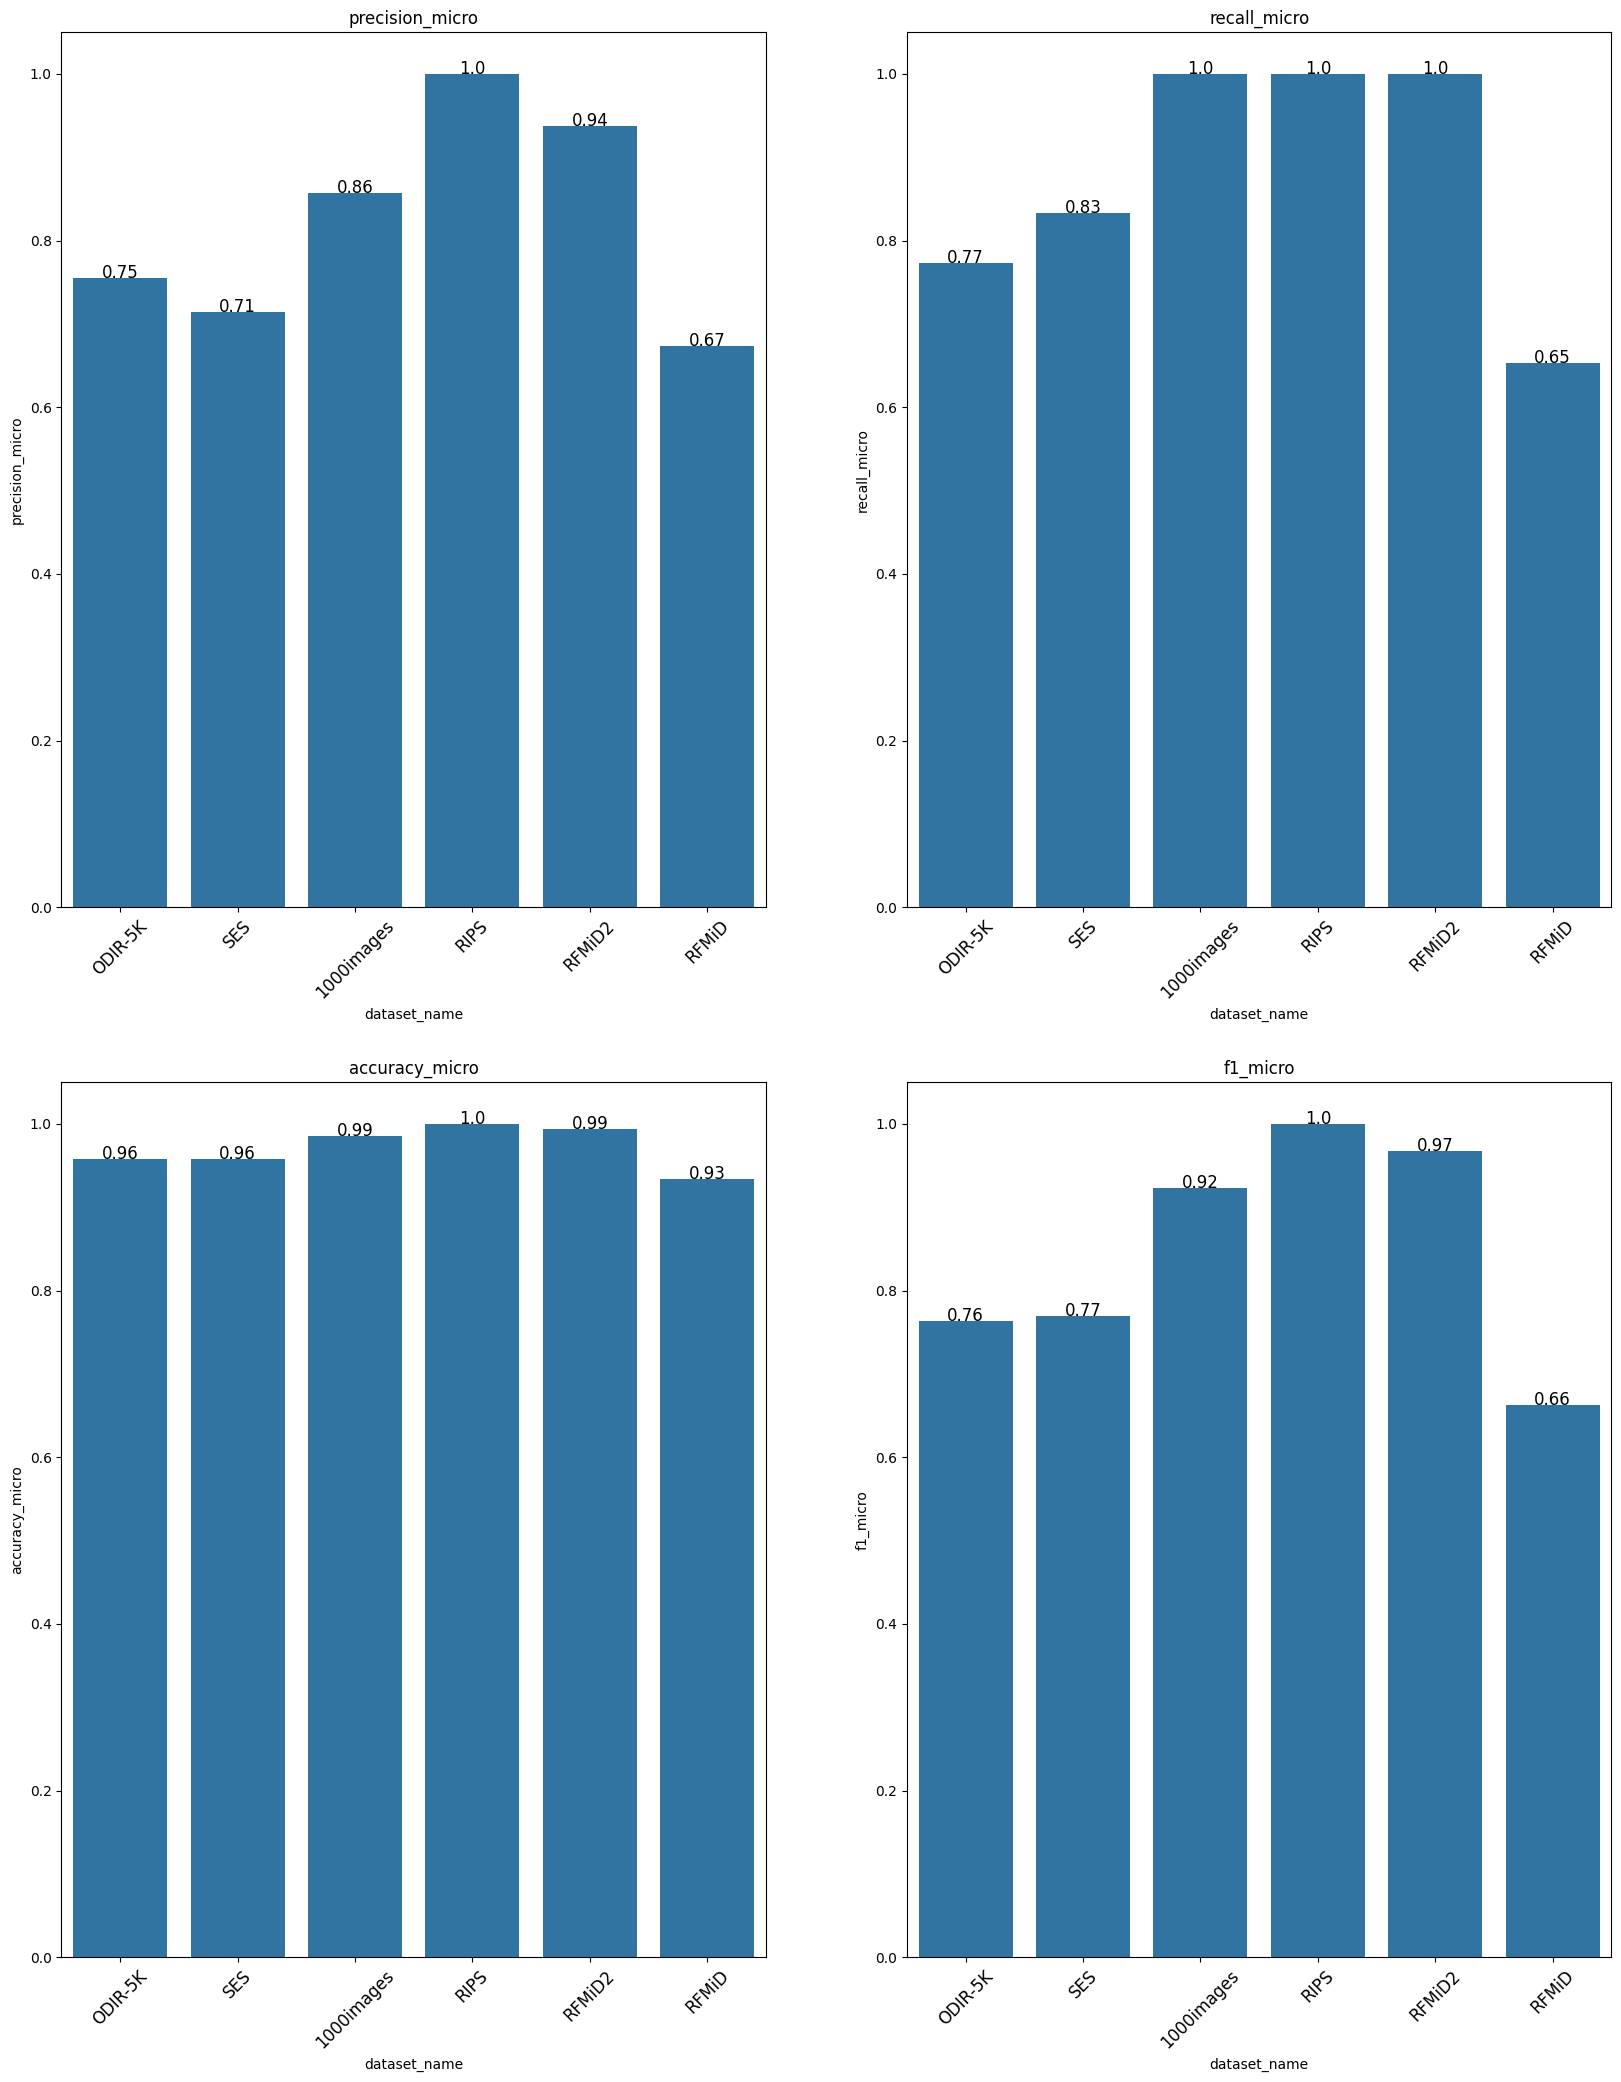

In [150]:
#plot the metrics grouped by dataset
fig, axes = plt.subplots(2, 2, figsize=(20, 25))
axes = axes.flatten()
metrics = ['precision_micro', 'recall_micro', 'accuracy_micro', 'f1_micro']
for i, metric in enumerate(metrics):
    sns.barplot(data=dataset_wise_metrics_df, x='dataset_name', y=metric, ax=axes[i])
    #add the value to the bar
    for index, row in dataset_wise_metrics_df.iterrows():
        axes[i].text(index, row[metric], round(row[metric], 2), color='black', ha="center", fontsize=12)
    axes[i].set_title(metric)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, fontsize=12)
plt.savefig(f'{dataset_wise_metrics_save_folder}/dataset_wise_metrics.png')

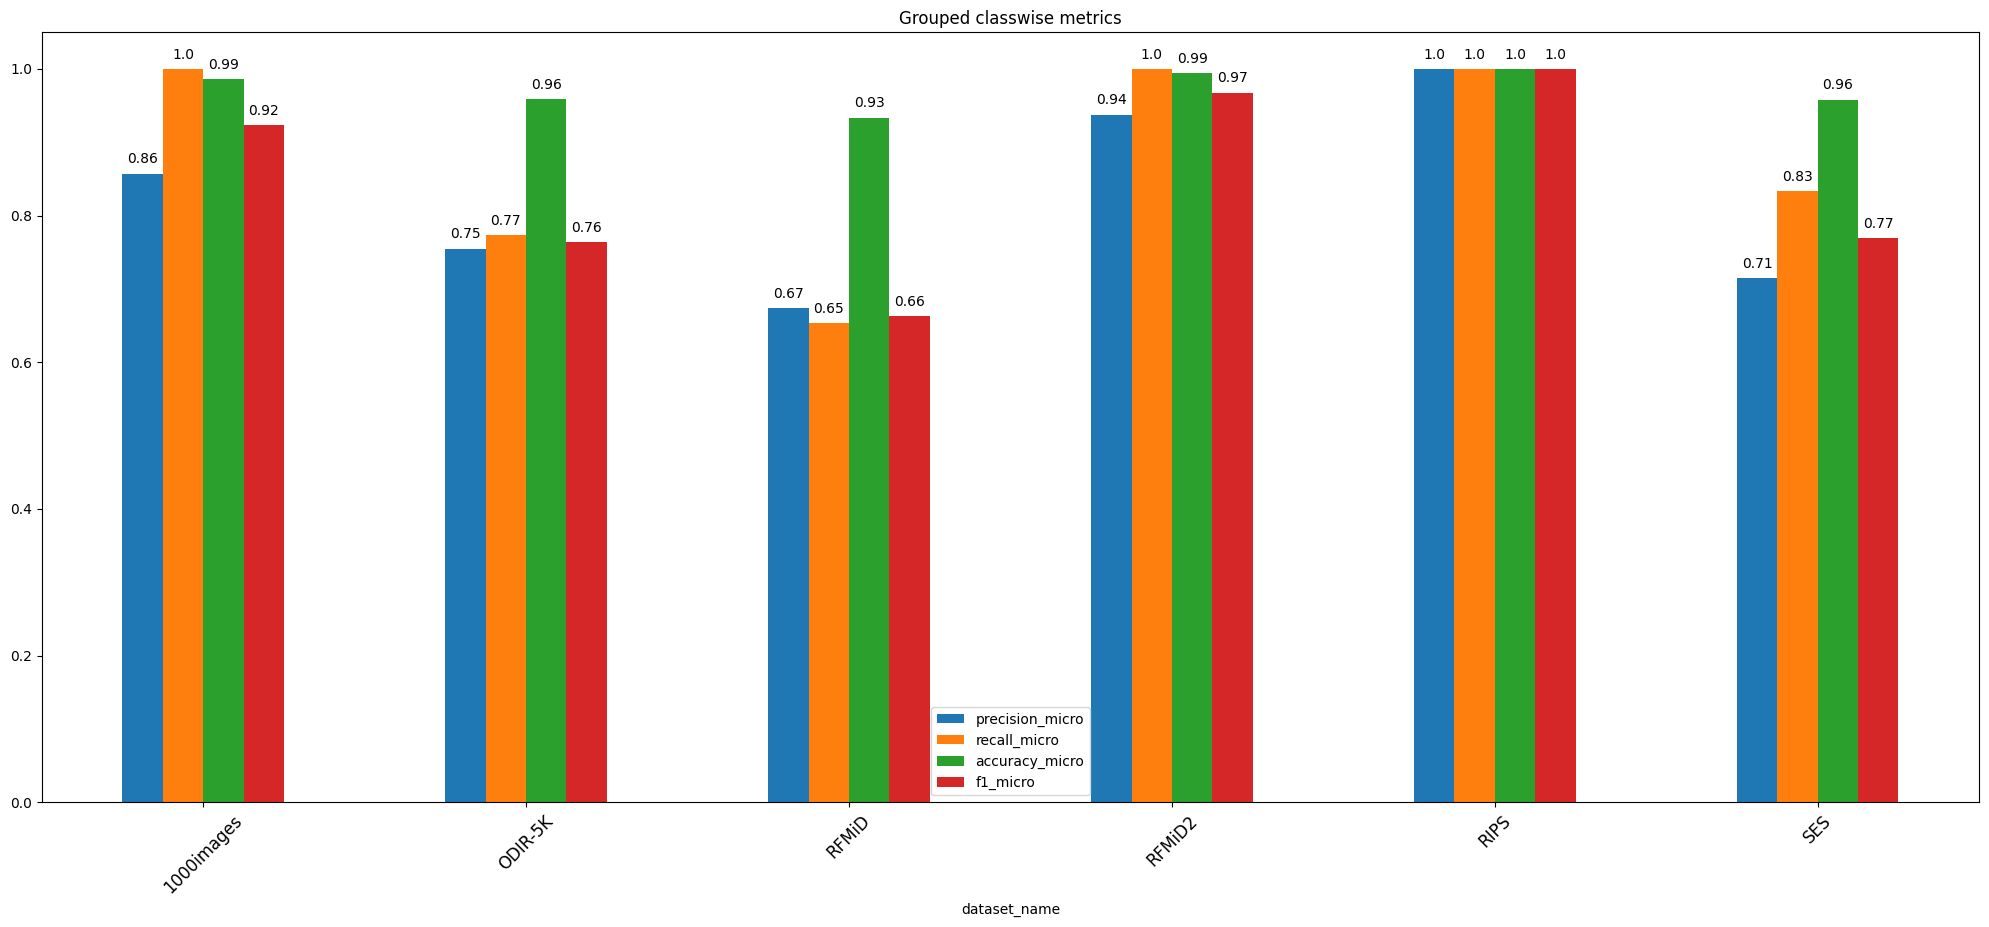

In [161]:
grouped_classwise_metrics = dataset_wise_metrics_df.groupby('dataset_name').mean()
grouped_classwise_metrics.head()
#plot the grouped df
ax = grouped_classwise_metrics.plot(kind='bar', figsize=(25, 10))
plt.title('Grouped classwise metrics')
#add the values to the bars
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 0.01, round(i.get_height(), 2), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.savefig(f'{dataset_wise_metrics_save_folder}/grouped_classwise_metrics.png')
plt.show()